In [4]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [397]:
%load_ext autoreload
%autoreload 2
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo, PFXYVideo
from MapMatching import MapMatching

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [423]:
class DynamicObjectTrack:
    def __init__(self, x, P, create_frame_idx):
        self.kf = KalmanFilter(dim_x=6, dim_z=4)
        self.kf.x = x.T # x,y,vx,vy
        self.kf.F = np.eye(6)
        self.kf.P = np.diag([2,2,0.5,0.5,3,3])
        self.kf.P_post = self.kf.P.copy()
        self.kf.Q = np.diag([0.5,0.5,1,1,0,0])
        self.kf.H = np.zeros([4,6])
        self.kf.H[0,0] = 1
        self.kf.H[1,1] = 1
        self.kf.H[2,2] = 1
        self.kf.H[3,3] = 1
        self.saver = Saver(self.kf)
        self.create_frame_idx = create_frame_idx
        self.last_update_frame_idx = create_frame_idx
        self.hits = 1
        self.age = 1
        self.confirmed = False
    
    def predict(self, dT):
        self.age += 1
        self.kf.F[0, 2] = dT
        self.kf.F[0, 4] = 0.5 * dT**2
        self.kf.F[1, 3] = dT
        self.kf.F[1, 5] = 0.5 * dT**2
        self.kf.F[2, 4] = dT
        self.kf.F[3, 5] = dT
        print(f"before predict: x={self.kf.P}")
        self.kf.predict()
        print(f"after predict: x={self.kf.P}")
        
    def update(self, z, cov, current_frame_idx):
        self.hits += 1
        self.kf.update(z,R=cov)
        self.last_update_frame_idx = current_frame_idx
        
    def save(self):
        self.saver.save()
        
    def getHistory(self):
        self.saver.to_array()
        return self.saver.x
    
    def getStateVector(self):
        return self.kf.x
    
    def getPredictedStateVector(self):
        return self.kf.x_prior
        
    def getInnovationCovarianceMatrix(self):
        return self.kf.S
    
    def getCovarianceMatrix(self):
        return self.kf.P_post
    
    def getLastUpdateFrameIdx(self):
        return self.last_update_frame_idx
    

class DynamicTracker:
    def __init__(self):
        self.pnt_data_associator = PointObjectDataAssociator(dim=4,delta=3)
        self.dyn_object_list = []
        self.dyn_max_non_update_iterations = 5
        self.frame_idx = 0
        self.history_dyn_object_list = []
        self.last_ts = 0

    def run(self, z, dz, ts):
        self.frame_idx += 1
        print(f"Number of new plots {len(z)}")
        print(f"Number of dynamic tracks before run() {len(self.dyn_object_list)}")
        
        
        #Prediction
        if self.last_ts > 0:
            dT = (ts - self.last_ts) / 1e6
            self.last_ts = ts
            
            for dyn_track in self.dyn_object_list:
                dyn_track.predict(dT)
        self.last_ts = ts
        
        #Association
        Gp = self.p2t(z)
        
        #Update
        z, dz = self.trackUpdate(z, dz, Gp)
        
        #Init
        self.trackInit(z,dz)
            
        #Maintenance
        self.trackMaintenance()
        
        return self.getTracks()
        
    def p2t(self, measurements):
        Gp = np.zeros((len(measurements), len(self.dyn_object_list)))
        for idx_z, z in enumerate(measurements):
            z = z.reshape(-1,1)
            for idx_track, dyn_track in enumerate(self.dyn_object_list):
                x = dyn_track.getStateVector()
                x_pred = dyn_track.getPredictedStateVector()
                innov_cov = dyn_track.getCovarianceMatrix()
                #print(f"p2t: z={z}, x_pred={x_pred} innov_cov={innov_cov}")
                Gp[idx_z,idx_track] = self.pnt_data_associator.calcLikelihood(z, x_pred[0:4], innov_cov[0:4,0:4])
        
        #print(f"Gp = {Gp}")
        return Gp
    
    def trackUpdate(self, z, dz, Gp):
        assigned_meas_list = []
        while(1): #Iterate over GP
            i_meas, lp, i_trk = self.getBestAssociation(Gp)
            if(lp == 0):
                break
            self.zeroOutAssociation(Gp, i_meas, i_trk) # Clear from point association matrix
            zm = z[i_meas]
            cov = dz[i_meas]
            assigned_meas_list.append(i_meas)

            print(f"Updating track = {i_trk} z = {zm} cov={cov}")
            self.dyn_object_list[i_trk].update(z=zm.T,cov=cov, current_frame_idx=self.frame_idx)
                
        for i_meas in sorted(assigned_meas_list, reverse=True):
            z = np.delete(z, (i_meas), axis=0)
            dz = np.delete(dz, (i_meas), axis=0)
        
        return z, dz
        
    def trackInit(self, z, dz):
        for z,cov in zip(z,dz):
            x = np.zeros(6)
            x[0:4] = z
            new_trk = DynamicObjectTrack(x=x.reshape(1,-1), P=cov, create_frame_idx=self.frame_idx)
            print(f"Initiating new track: x={x}")
            self.dyn_object_list.append(new_trk)

            
    def deleteTrack(self, track_list, indices):
        delete_indices  = np.unique(indices)
        #print("deleteTrack is called. track list length:", len(track_list), "indices", indices)
        for index in sorted(delete_indices, reverse=True):
            self.history_dyn_object_list.append(track_list[index])
            del track_list[index]
        
    def trackMaintenance(self):
        dyn_delete_list = []
        for i_trk,trk in enumerate(self.dyn_object_list):
            trk.save()
            print(f"age = {trk.age} hits = {trk.hits}")
            if trk.age > 10 and (float(trk.hits) / trk.age) > 0.5:
                trk.confirmed = True
            if self.frame_idx - trk.getLastUpdateFrameIdx() > self.dyn_max_non_update_iterations:
                dyn_delete_list.append(i_trk)

        self.deleteTrack(self.dyn_object_list, dyn_delete_list)
        
    def isTrkSimilar(self, x_cand):
        x, y, vx, vy = x_cand[0], x_cand[1], x_cand[2], x_cand[3]
        for trk in self.dyn_object_list:
            state_adv = trk.getStateVector()
            x_adv, y_adv, vx_adv, vy_adv = state_adv[0], state_adv[1], state_adv[2], state_adv[3] 
            
            pos_thr = 4
            vel_thr = 1
            pos_dist = sqrt((x-x_adv)**2+(y-y_adv)**2)
            vel_dist = sqrt((vx-vx_adv)**2+(vy-vy_adv)**2)
            if dist > dist_thr or vel_dist > vel_thr:
                return True
        
        return False
                
                    
    @staticmethod
    def getBestAssociation(Gp):
        i_meas,lp,i_trk_p = None,0,None
        if Gp.size > 0:
            ind = np.unravel_index(np.argmax(Gp, axis=None), Gp.shape)
            i_meas = ind[0]
            i_trk_p = ind[1]
            lp = Gp[ind]
        
        return i_meas,lp, i_trk_p
    
    @staticmethod
    def zeroOutAssociation(mat, i, j, k=None):
        if mat is not None:
            if mat.ndim == 2:
                mat[i, :] = 0
                mat[:, j] = 0
            elif mat.ndim == 3:
                mat[i, :, k] = 0
                mat[:, j, k] = 0
        
        return mat
          
    @staticmethod
    def createProbabilityMatrix(pairs):
        if pairs:
            u_meas = np.unique([item[0] for item in pairs])
            u_trk = np.unique([item[1] for item in pairs])
            P = np.zeros((len(u_meas),len(u_trk)))
            for i in range(0, len(u_meas)):
                for j in range(0, len(u_trk)):
                    P[i,j] = max([pair[2] if pair[0]==u_meas[i] and pair[1]==u_trk[j] else 0 for pair in pairs])
        else:
            P = None
            
        #print("createProbabilityMatrix: P = ", P)
 
        return P
    
    def getTracks(self):
        return self.dyn_object_list
    
    def getHistory(self):
        return self.history_dyn_object_list + self.dyn_object_list 

In [400]:
scene_id = 426
N = 800

dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=scene_id, N=N)

scene_id=426 scene_name=scene-0536 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:311: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.first_gt_trns = self.ego.iloc[eidx]["translation"]


odom_speed [[1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 [1.53565927e+15 0.00000000e+00]
 ...
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]
 [1.53565951e+15 1.00000000e+00]]


/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pidx = np.argsort(np.abs(veh_speed[:,0]-ts))[0]
/home/kfir/workspace/RadarLocalization/dataset.py:253: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this

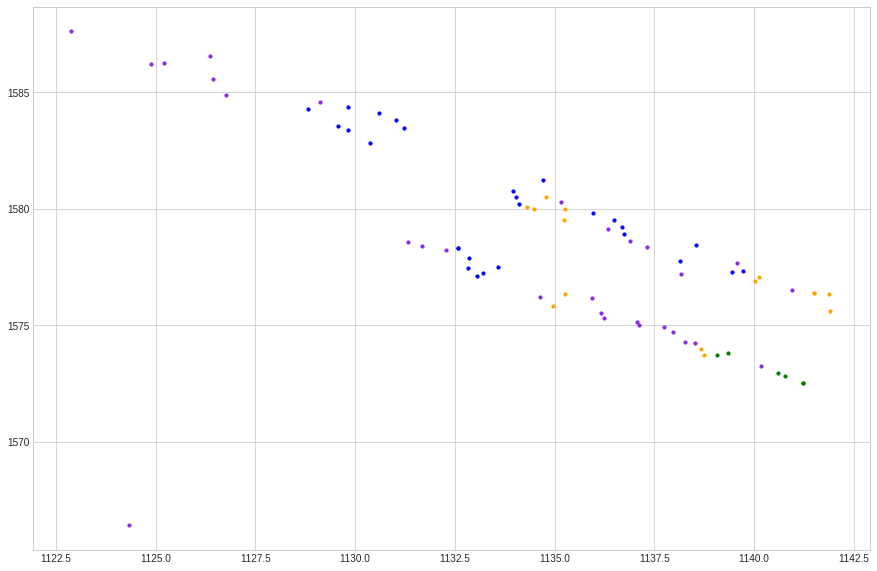

In [91]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,20):
    pc = dataset.getDynamicPoints(t)
    pc = np.squeeze(pc[np.where(pc[:,3]==0) or np.where(pc[:,3]==2) or np.where(pc[:,3]==6), :], axis=0)
    clus = DBSCAN(eps=2, min_samples=2).fit(pc[:,0:2])
    c = clus.labels_
    for i in range(pc.shape[0]):
        v_comp = np.sqrt(pc[i,8]**2 + pc[i,9]**2)
        if v_comp > 3:
            #c = int(np.round(v_comp) % 17)
            ax.scatter(pc[i,0], pc[i,1], s=10, c=colors[c[i]])

n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-3.8463508293548716 vy_com=1.9916254777472748 pc[c==i,6]=[4.  4.5 4.5] pc[c==i,7]=[0. 0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-3.550425581772953 vy_com=1.8385232678874637 pc[c==i,6]=[3.75 4.25] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-3.6058211359631294 vy_com=1.8674057750506683 pc[c==i,6]=[4.   3.75 4.25 4.25] pc[c==i,7]=[0. 0. 0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-3.550361800854347 vy_com=1.8386312662218152 pc[c==i,6]=[3.75 4.25] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-3.402448904535783 vy_com=1.761969187819278 pc[c==i,6]=[3.75 3.75 4.  ] pc[c==i,7]=[0. 0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-3.254528582478958 vy_com=1.6853454486840382 pc[c==i,6]=[3.5 3.5 4. ] pc[c==i,7]=[0. 0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-3.2175117972302543 vy_com=1.6662525541440187 pc[c==i,6]=[3.25 4.  ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.9955928332438884 vy_com=1.5513753132038404 pc[c==i,6]=[3.25 3.5 ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.9956127636748553 vy_com=1.5513412701648406 pc[c==i,6]=[3.25 3.5 ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.662759946138851 vy_com=1.3789750471417501 pc[c==i,6]=[3.] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.6627043115681257 vy_com=1.3790684502444266 pc[c==i,6]=[3. 3.] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.3298244024749257 vy_com=1.2067617103997237 pc[c==i,6]=[2.5  2.75] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.218881227953778 vy_com=1.1492989681474262 pc[c==i,6]=[2.5 2.5] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 2
vx_com=-2.218849432857964 vy_com=1.149354999293958 pc[c==i,6]=[2.5] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.218861767160108 vy_com=1.1493029923750846 pc[c==i,6]=[2.5] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.218855852834731 vy_com=1.149311489602737 pc[c==i,6]=[2.5] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.218854292689738 vy_com=1.1493165695817051 pc[c==i,6]=[2.5] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-1.9969467209952954 vy_com=1.0344285611600372 pc[c==i,6]=[2.25] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 2
vx_com=-1.6641424945922454 vy_com=0.8619833931396769 pc[c==i,6]=[1.75 2.  ] pc[c==i,7]=[0. 0.]
vx_com=-2.329799492429143 vy_com=1.2067767503955475 pc[c==i,6]=[2.75 2.5 ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 2
vx_com=-1.6641296018744527 vy_com=0.8620112233414724 pc[c==i,6]=[1.75 2.  ] pc[c==i,7]=[0. 0.]
vx_com=-2.329781442624234 vy_com=1.2068157126780614 pc[c==i,6]=[2.75 2.5 ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.1078973568035533 vy_com=1.0918823412271654 pc[c==i,6]=[2.   2.75] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-1.9969457829233508 vy_com=1.0344442759159482 pc[c==i,6]=[1.75 2.75] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0
vx_com=-1.4422506218940923 vy_com=0.7470751078411035 pc[c==i,6]=[1.5  1.75] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-1.2203846180138689 vy_com=0.6321001011876989 pc[c==i,6]=[1.25 1.5 ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.884611689315748 vy_com=1.4939182771003847 pc[c==i,6]=[3.25 3.25] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-2.440461093308009 vy_com=1.264858158316549 pc[c==i,6]=[3.5 2. ] pc[c==i,7]=[0. 0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=-3.1061599916144154 vy_com=1.6096682637417359 pc[c==i,6]=[3.5] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=0.4042842510122212 vy_com=-0.44255962865256554 pc[c==i,6]=[0.] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=1.2377356452834538 vy_com=-0.6748621495197096 pc[c==i,6]=[-0.5] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=1.3810424381383242 vy_com=-0.6751723069093133 pc[c==i,6]=[-0.5] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=1.7386165641597775 vy_com=-0.7927352750644678 pc[c==i,6]=[-0.75] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=1.8322183164406947 vy_com=-0.79333658591186 pc[c==i,6]=[-0.75] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=2.3749694757039856 vy_com=-0.9129892302275104 pc[c==i,6]=[-1.] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=2.709085128569612 vy_com=-1.0323236786926822 pc[c==i,6]=[-1.25] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=2.58901017771378 vy_com=-0.914275583215135 pc[c==i,6]=[-1.] pc[c==i,7]=[0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=2.8704533764946003 vy_com=-0.9749669027892832 pc[c==i,6]=[-1.25 -1.  ] pc[c==i,7]=[0.5 0.5]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 1
vx_com=2.493400980231137 vy_com=0.0 pc[c==i,6]=[0.] pc[c==i,7]=[0.]


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


n_clusters 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


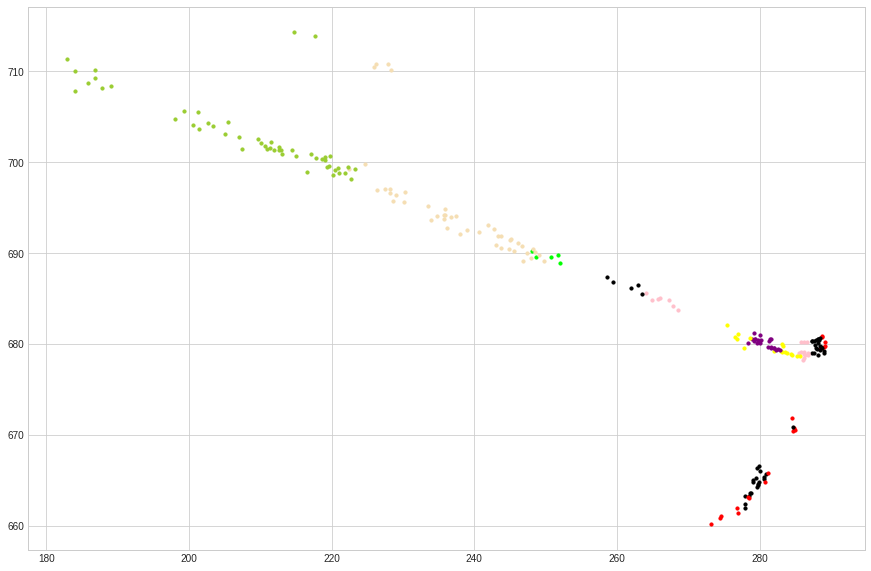

In [442]:
from sklearn.cluster import DBSCAN

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

for t in range(0,150):
    pc, ts = dataset.getDynamicPoints(t)
    if pc.shape[0] < 1:
        continue
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+8:9])
    c = clus.labels_
    n_clusters = np.unique(c)
    print(f"n_clusters {len(n_clusters)-1}")
    for i in n_clusters:
        if c[i] == -1:
            continue
        x_com = pc[c==i,0]
        y_com = pc[c==i,1]
        vx_com = np.mean(pc[c==i,8])
        vy_com = np.mean(pc[c==i,9])
        if np.mean(y_com) < 670:
            #print(f"pc[c==i,:] = {pc[c==i,:]}")
            print(f"vx_com={vx_com} vy_com={vy_com} pc[c==i,6]={pc[c==i,6]} pc[c==i,7]={pc[c==i,7]}")
        #print(f"vy_com={vy_com}")
        v_comp = np.sqrt(vx_com**2 + vy_com**2)
        if v_comp > 3:
            color = int(np.round(v_comp) % 17)
            ax.scatter(x_com, y_com, s=10, c=colors[color])

In [424]:
from sklearn.cluster import DBSCAN
import numpy as np

def calcClusterProperiesArray(ci):
    x_com = np.mean(ci[:,0])
    y_com = np.mean(ci[:,1])
    vx_com = 1*np.mean(ci[:,8])
    vy_com = 1*np.mean(ci[:,9])
    if vy_com > 0:
        print(f"vx_com {vx_com} vy_com {vy_com}")
    v_comp = np.sqrt(vx_com**2 + vy_com**2)
    if v_comp < 2:
        return None, None
    x_var = np.var(ci[:,0]) + 2
    y_var = np.var(ci[:,1]) + 2
    vx_var = np.var(ci[:,8]) + 0.5
    vy_var = np.var(ci[:,9]) + 0.5
    X = np.array([x_com, y_com, vx_com, vy_com])
    P = np.diag([x_var, y_var, vx_var, vy_var])
    
    return X,P

def calcClusterProperiesScalar(ci):
    x_com = ci[0]
    y_com = ci[1]
    vx_com = ci[8]
    vy_com = ci[9]
    v_comp = np.sqrt(vx_com**2 + vy_com**2)
    if v_comp < 2:
        return None, None
    x_var = ci[0] + 2
    y_var = ci[1] + 2
    vx_var = ci[8] + 0.5
    vy_var = ci[9] + 0.5
    X = np.array([x_com, y_com, vx_com, vy_com])
    P = np.diag([x_var, y_var, vx_var, vy_var])
    
    return X,P


def runClustering(pc):
    X_list = []
    P_list = []
    
    if pc.shape[0] < 1:
        return X_list, P_list
    clus = DBSCAN(eps=3, min_samples=2).fit(pc[:,0:2+8:10])
    c = clus.labels_
    n_clusters = np.unique(c)
    for i in n_clusters:
        ci = pc[c==i, :]
        if i == -1:
            continue #don't consider 1 point clusters
            for j in range(ci.shape[0]):
                X, P = calcClusterProperiesScalar(ci[j, :])
                if X is not None:
                    X_list.append(X)
                    P_list.append(P)
        else:
            X, P = calcClusterProperiesArray(ci)
            if X is not None:
                X_list.append(X)
                P_list.append(P)
        
    return X_list, P_list

In [428]:
tracker = DynamicTracker()
n_frames = 200
for t in range(0,n_frames):
    pc, ts = dataset.getDynamicPoints(t)
    X, P = runClustering(pc)
    #print(f"X={X} P={P}")
    tracker.run(X, P, ts)
    


vx_com -10.206953828709352 vy_com 5.287035840242179
Number of new plots 1
Number of dynamic tracks before run() 0
Initiating new track: x=[251.82635509 689.33273911 -10.20695383   5.28703584   0.
   0.        ]
age = 1 hits = 1


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.206819109492862 vy_com 5.287306636002834
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[2.  0.  0.  0.  0.  0. ]
 [0.  2.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  3.  0. ]
 [0.  0.  0.  0.  0.  3. ]]
after predict: x=[[2.50247241 0.         0.03554687 0.         0.00736303 0.        ]
 [0.         2.50247241 0.         0.03554687 0.         0.00736303]
 [0.03554687 0.         1.51472605 0.         0.210186   0.        ]
 [0.         0.03554687 0.         1.51472605 0.         0.210186  ]
 [0.00736303 0.         0.210186   0.         3.         0.        ]
 [0.         0.00736303 0.         0.210186   0.         3.        ]]
Updating track = 0 z = [249.42298957 689.91663665 -10.20681911   5.28730664] cov=[[3.66536652 0.         0.         0.        ]
 [0.         2.11396193 0.         0.        ]
 [0.         0.         0.5        0.        ]
 [0.         0.         0.         0.5       ]]
age

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.262344257291964 vy_com 5.315931803539314
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.48692475e+00 0.00000000e+00 5.24304874e-03 0.00000000e+00
  2.17204524e-03 0.00000000e+00]
 [0.00000000e+00 1.14580297e+00 0.00000000e+00 4.04021848e-03
  0.00000000e+00 1.67374704e-03]
 [5.24304874e-03 0.00000000e+00 3.75901032e-01 0.00000000e+00
  5.21571991e-02 0.00000000e+00]
 [0.00000000e+00 4.04021848e-03 0.00000000e+00 3.75896791e-01
  0.00000000e+00 5.21554420e-02]
 [2.17204524e-03 0.00000000e+00 5.21571991e-02 0.00000000e+00
  2.97807021e+00 0.00000000e+00]
 [0.00000000e+00 1.67374704e-03 0.00000000e+00 5.21554420e-02
  0.00000000e+00 2.97806948e+00]]
after predict: x=[[1.98988246 0.         0.03466098 0.         0.0144558  0.        ]
 [0.         1.64857747 0.         0.03342045 0.         0.01395737]
 [0.03466098 0.         1.40046854 0.         0.27547077 0.        ]
 [0.         0.03342045 0.         1.40046403 0.         0.27546896]
 [0.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.428846121697173 vy_com 5.401954594335419
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.21147527 0.         0.00562879 0.         0.00575881 0.        ]
 [0.         0.96494044 0.         0.00516713 0.         0.00533966]
 [0.00562879 0.         0.37342545 0.         0.07343854 0.        ]
 [0.         0.00516713 0.         0.36977696 0.         0.07271813]
 [0.00575881 0.         0.07343854 0.         2.93831648 0.        ]
 [0.         0.00533966 0.         0.07271813 0.         2.93817179]]
after predict: x=[[1.71417324 0.         0.03327242 0.         0.01813665 0.        ]
 [0.         1.46755339 0.         0.03252011 0.         0.01766662]
 [0.03327242 0.         1.39818113 0.         0.27952324 0.        ]
 [0.         0.03252011 0.         1.39443088 0.         0.27879268]
 [0.01813665 0.         0.27952324 0.         2.93831648 0.        ]
 [0.         0.01766662 0.         0.27879268 0.         2.93817179]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.428938559207522 vy_com 5.401769144920462
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.14316884 0.         0.00584683 0.         0.00883066 0.        ]
 [0.         0.89028565 0.         0.00520888 0.         0.00781707]
 [0.00584683 0.         0.36828005 0.         0.0736067  0.        ]
 [0.         0.00520888 0.         0.3680145  0.         0.07355255]
 [0.00883066 0.         0.0736067  0.         2.89712027 0.        ]
 [0.         0.00781707 0.         0.07355255 0.         2.89709899]]
after predict: x=[[1.64621522 0.         0.0353276  0.         0.02247518 0.        ]
 [0.         1.39322924 0.         0.03459336 0.         0.02145748]
 [0.0353276  0.         1.39556909 0.         0.29065026 0.        ]
 [0.         0.03459336 0.         1.39529531 0.         0.29059451]
 [0.02247518 0.         0.29065026 0.         2.89712027 0.        ]
 [0.         0.02145748 0.         0.29059451 0.         2.89709899]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.650919558327542 vy_com 5.516523661865884
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.04351587 0.         0.00590923 0.         0.01081741 0.        ]
 [0.         0.91587127 0.         0.00600198 0.         0.01062368]
 [0.00590923 0.         0.36809418 0.         0.07663036 0.        ]
 [0.         0.00600198 0.         0.36807396 0.         0.07662583]
 [0.01081741 0.         0.07663036 0.         2.85248977 0.        ]
 [0.         0.01062368 0.         0.07662583 0.         2.85247969]]
after predict: x=[[1.54624464 0.         0.03349421 0.         0.02317594 0.        ]
 [0.         1.41861198 0.         0.03357195 0.         0.02298186]
 [0.03349421 0.         1.39281124 0.         0.27636454 0.        ]
 [0.         0.03357195 0.         1.39279033 0.         0.27635931]
 [0.02317594 0.         0.27636454 0.         2.85248977 0.        ]
 [0.         0.02298186 0.         0.27635931 0.         2.85247969]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.650787873233977 vy_com 5.516778330800872
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.03357847 0.         0.00591649 0.         0.01222755 0.        ]
 [0.         0.91857232 0.         0.00574482 0.         0.01171208]
 [0.00591649 0.         0.36790455 0.         0.07296905 0.        ]
 [0.         0.00574482 0.         0.36790033 0.         0.07296332]
 [0.01222755 0.         0.07296905 0.         2.81206682 0.        ]
 [0.         0.01171208 0.         0.07296332 0.         2.8120483 ]]
after predict: x=[[1.54387489 0.         0.06782722 0.         0.0525658  0.        ]
 [0.         1.4288078  0.         0.06757977 0.         0.0520493 ]
 [0.06782722 0.         1.44858105 0.         0.48186325 0.        ]
 [0.         0.06757977 0.         1.44857477 0.         0.48185483]
 [0.0525658  0.         0.48186325 0.         2.81206682 0.        ]
 [0.         0.0520493  0.         0.48185483 0.         2.8120483 ]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.650458471524361 vy_com 5.517415400202214
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.00923762 0.         0.01139466 0.         0.02343378 0.        ]
 [0.         0.90792392 0.         0.01103718 0.         0.02249199]
 [0.01139466 0.         0.37163366 0.         0.12350511 0.        ]
 [0.         0.01103718 0.         0.37162447 0.         0.12348673]
 [0.02343378 0.         0.12350511 0.         2.69262022 0.        ]
 [0.         0.02249199 0.         0.12348673 0.         2.69257422]]
after predict: x=[[1.51321541 0.         0.04249313 0.         0.0401663  0.        ]
 [0.         1.411843   0.         0.04206446 0.         0.03922301]
 [0.04249313 0.         1.4050987  0.         0.32459538 0.        ]
 [0.         0.04206446 0.         1.40508651 0.         0.32457356]
 [0.0401663  0.         0.32459538 0.         2.69262022 0.        ]
 [0.         0.03922301 0.         0.32457356 0.         2.69257422]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.650530362462668 vy_com 5.517294187540347
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.96632062 0.         0.0071263  0.         0.02103945 0.        ]
 [0.         0.94071895 0.         0.00736088 0.         0.02137342]
 [0.0071263  0.         0.36874351 0.         0.08510356 0.        ]
 [0.         0.00736088 0.         0.36874357 0.         0.08510245]
 [0.02103945 0.         0.08510356 0.         2.63705606 0.        ]
 [0.         0.02137342 0.         0.08510245 0.         2.63703323]]
after predict: x=[[1.4692724  0.         0.03548374 0.         0.03345425 0.        ]
 [0.         1.44370521 0.         0.0357417  0.         0.03378809]
 [0.03548374 0.         1.39357311 0.         0.26966584 0.        ]
 [0.         0.0357417  0.         1.39357291 0.         0.26966313]
 [0.03345425 0.         0.26966584 0.         2.63705606 0.        ]
 [0.         0.03378809 0.         0.26966313 0.         2.63703323]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.650483812238734 vy_com 5.517365568236519
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.9675622  0.         0.00617292 0.         0.0187114  0.        ]
 [0.         1.03084526 0.         0.00674188 0.         0.02050083]
 [0.00617292 0.         0.36795407 0.         0.07114373 0.        ]
 [0.         0.00674188 0.         0.36795682 0.         0.07115123]
 [0.0187114  0.         0.07114373 0.         2.59846527 0.        ]
 [0.         0.02050083 0.         0.07115123 0.         2.59846756]]
after predict: x=[[1.47071835 0.         0.03634839 0.         0.0313724  0.        ]
 [0.         1.53409693 0.         0.03705195 0.         0.0331624 ]
 [0.03634839 0.         1.39327606 0.         0.26619493 0.        ]
 [0.         0.03705195 0.         1.39327995 0.         0.2662026 ]
 [0.0313724  0.         0.26619493 0.         2.59846527 0.        ]
 [0.         0.0331624  0.         0.2662026  0.         2.59846756]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.02843268 0.         0.00671574 0.         0.01837287 0.        ]
 [0.         0.95676028 0.         0.00610551 0.         0.01744135]
 [0.00671574 0.         0.36793492 0.         0.07024857 0.        ]
 [0.         0.00610551 0.         0.36793054 0.         0.07023489]
 [0.01837287 0.         0.07024857 0.         2.56089728 0.        ]
 [0.         0.01744135 0.         0.07023489 0.         2.56084681]]
after predict: x=[[1.53166226 0.         0.03681792 0.         0.03084168 0.        ]
 [0.         1.45989306 0.         0.03613738 0.         0.02990899]
 [0.03681792 0.         1.39287253 0.         0.26229282 0.        ]
 [0.         0.03613738 0.         1.39286582 0.         0.26227535]
 [0.03084168 0.         0.26229282 0.         2.56089728 0.        ]
 [0.         0.02990899 0.         0.26227535 0.         2.56084681]]
age = 11 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.53166226 0.         0.03681792 0.         0.03084168 0.        ]
 [0.         1.45989306 0.         0.03613738 0.         0.02990899]
 [0.03681792 0.         1.39287253 0.         0.26229282 0.        ]
 [0.         0.03613738 0.         1.39286582 0.         0.26227535]
 [0.03084168 0.         0.26229282 0.         2.56089728 0.        ]
 [0.         0.02990899 0.         0.26227535 0.         2.56084681]]
after predict: x=[[2.04392914 0.         0.13901121 0.         0.0555254  0.        ]
 [0.         1.9720599  0.         0.13826467 0.         0.05459136]
 [0.13901121 0.         2.44223998 0.         0.44183989 0.        ]
 [0.         0.13826467 0.         2.44223057 0.         0.44181888]
 [0.0555254  0.         0.44183989 0.         2.56089728 0.        ]
 [0.         0.05459136 0.         0.44181888 0.         2.56084681]]
age = 12 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[2.04392914 0.         0.13901121 0.         0.0555254  0.        ]
 [0.         1.9720599  0.         0.13826467 0.         0.05459136]
 [0.13901121 0.         2.44223998 0.         0.44183989 0.        ]
 [0.         0.13826467 0.         2.44223057 0.         0.44181888]
 [0.0555254  0.         0.44183989 0.         2.56089728 0.        ]
 [0.         0.05459136 0.         0.44181888 0.         2.56084681]]
after predict: x=[[2.64359107 0.         0.53276213 0.         0.15056771 0.        ]
 [0.         2.57147665 0.         0.53187333 0.         0.14962995]
 [0.53276213 0.         3.63232459 0.         0.82583875 0.        ]
 [0.         0.53187333 0.         3.63230774 0.         0.82581018]
 [0.15056771 0.         0.82583875 0.         2.56089728 0.        ]
 [0.         0.14962995 0.         0.82581018 0.         2.56084681]]
age = 13 hits = 10


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.872747584665513 vy_com 5.631587431772172
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[2.64359107 0.         0.53276213 0.         0.15056771 0.        ]
 [0.         2.57147665 0.         0.53187333 0.         0.14962995]
 [0.53276213 0.         3.63232459 0.         0.82583875 0.        ]
 [0.         0.53187333 0.         3.63230774 0.         0.82581018]
 [0.15056771 0.         0.82583875 0.         2.56089728 0.        ]
 [0.         0.14962995 0.         0.82581018 0.         2.56084681]]
after predict: x=[[3.23704796 0.         0.80416115 0.         0.21467273 0.        ]
 [0.         3.16480437 0.         0.80320529 0.         0.21373285]
 [0.80416115 0.         4.76053464 0.         1.0051579  0.        ]
 [0.         0.80320529 0.         4.76051354 0.         1.00512579]
 [0.21467273 0.         1.0051579  0.         2.56089728 0.        ]
 [0.         0.21373285 0.         1.00512579 0.         2.56084681]]
Initiating new track:

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -10.872759866716608 vy_com 5.63153239036391
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.23704796 0.         0.80416115 0.         0.21467273 0.        ]
 [0.         3.16480437 0.         0.80320529 0.         0.21373285]
 [0.80416115 0.         4.76053464 0.         1.0051579  0.        ]
 [0.         0.80320529 0.         4.76051354 0.         1.00512579]
 [0.21467273 0.         1.0051579  0.         2.56089728 0.        ]
 [0.         0.21373285 0.         1.00512579 0.         2.56084681]]
after predict: x=[[3.88762499 0.         1.18967158 0.         0.29803004 0.        ]
 [0.         3.81523129 0.         1.18864274 0.         0.29708759]
 [1.18967158 0.         5.92724926 0.         1.19886673 0.        ]
 [0.         1.18864274 0.         5.92722302 0.         1.19883081]
 [0.29803004 0.         1.19886673 0.         2.56089728 0.        ]
 [0.         0.29708759 0.         1.19883081 0.         2.56084681]]
before predict: x=[[2.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.020898143378588 vy_com 5.707765281115749
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.88762499 0.         1.18967158 0.         0.29803004 0.        ]
 [0.         3.81523129 0.         1.18864274 0.         0.29708759]
 [1.18967158 0.         5.92724926 0.         1.19886673 0.        ]
 [0.         1.18864274 0.         5.92722302 0.         1.19883081]
 [0.29803004 0.         1.19886673 0.         2.56089728 0.        ]
 [0.         0.29708759 0.         1.19883081 0.         2.56084681]]
after predict: x=[[4.58340461 0.         1.63130172 0.         0.38750588 0.        ]
 [0.         4.51086326 0.         1.63020531 0.         0.38656081]
 [1.63130172 0.         7.10620093 0.         1.37679275 0.        ]
 [0.         1.63020531 0.         7.10616946 0.         1.37675332]
 [0.38750588 0.         1.37679275 0.         2.56089728 0.        ]
 [0.         0.38656081 0.         1.37675332 0.         2.56084681]]
before predict: x=[[1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.020833232331645 vy_com 5.707918457190849
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.19164626 0.         0.00548457 0.         0.0056605  0.        ]
 [0.         0.96937631 0.         0.00444871 0.         0.00463438]
 [0.00548457 0.         0.37418569 0.         0.07034393 0.        ]
 [0.         0.00444871 0.         0.36986871 0.         0.06952852]
 [0.0056605  0.         0.07034393 0.         2.93825038 0.        ]
 [0.         0.00463438 0.         0.06952852 0.         2.93809308]]
after predict: x=[[1.69466047 0.         0.03519813 0.         0.01920826 0.        ]
 [0.         1.47220466 0.         0.03375446 0.         0.01812052]
 [0.03519813 0.         1.40128122 0.         0.29079498 0.        ]
 [0.         0.03375446 0.         1.396841   0.         0.28996776]
 [0.01920826 0.         0.29079498 0.         2.93825038 0.        ]
 [0.         0.01812052 0.         0.28996776 0.         2.93809308]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.094787361941668 vy_com 5.746237081516879
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.13511449 0.         0.00630196 0.         0.0092843  0.        ]
 [0.         0.89212511 0.         0.0054172  0.         0.00786184]
 [0.00630196 0.         0.37440201 0.         0.07767439 0.        ]
 [0.         0.0054172  0.         0.36976974 0.         0.07673328]
 [0.0092843  0.         0.07767439 0.         2.89399131 0.        ]
 [0.         0.00786184 0.         0.07673328 0.         2.89378954]]
after predict: x=[[1.63791804 0.         0.03420995 0.         0.0218003  0.        ]
 [0.         1.3947749  0.         0.03289467 0.         0.0203115 ]
 [0.03420995 0.         1.39943401 0.         0.28013513 0.        ]
 [0.         0.03289467 0.         1.39466907 0.         0.2791799 ]
 [0.0218003  0.         0.28013513 0.         2.89399131 0.        ]
 [0.         0.0203115  0.         0.2791799  0.         2.89378954]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.08653061 0.         0.00597601 0.         0.01111872 0.        ]
 [0.         0.85623648 0.         0.00533126 0.         0.00949735]
 [0.00597601 0.         0.36836518 0.         0.07371074 0.        ]
 [0.         0.00533126 0.         0.36802998 0.         0.07363795]
 [0.01111872 0.         0.07371074 0.         2.85261833 0.        ]
 [0.         0.00949735 0.         0.07363795 0.         2.85258614]]
after predict: x=[[1.59716781 0.         0.06909372 0.         0.05318008 0.        ]
 [0.         1.36664008 0.         0.06815731 0.         0.05154759]
 [0.06909372 0.         1.45248789 0.         0.49538193 0.        ]
 [0.         0.06815731 0.         1.45213047 0.         0.49530439]
 [0.05318008 0.         0.49538193 0.         2.85261833 0.        ]
 [0.         0.05154759 0.         0.49530439 0.         2.85258614]]
age = 6 hits = 5


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.59716781 0.         0.06909372 0.         0.05318008 0.        ]
 [0.         1.36664008 0.         0.06815731 0.         0.05154759]
 [0.06909372 0.         1.45248789 0.         0.49538193 0.        ]
 [0.         0.06815731 0.         1.45213047 0.         0.49530439]
 [0.05318008 0.         0.49538193 0.         2.85261833 0.        ]
 [0.         0.05154759 0.         0.49530439 0.         2.85258614]]
after predict: x=[[2.11521452 0.         0.18228033 0.         0.09641053 0.        ]
 [0.         1.88454108 0.         0.18119955 0.         0.09477236]
 [0.18228033 0.         2.5389488  0.         0.70145793 0.        ]
 [0.         0.18119955 0.         2.53858    0.         0.70137806]
 [0.09641053 0.         0.70145793 0.         2.85261833 0.        ]
 [0.         0.09477236 0.         0.70137806 0.         2.85258614]]
age = 7 hits = 5
Number of new plots 0
Number of dynamic tracks before ru

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.094459696299879 vy_com 5.746835663677395
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.33863678 0.         0.02650189 0.         0.03790008 0.        ]
 [0.         1.24468114 0.         0.02653674 0.         0.0374457 ]
 [0.02650189 0.         0.45214288 0.         0.10414916 0.        ]
 [0.         0.02653674 0.         0.45208824 0.         0.10409029]
 [0.03790008 0.         0.10414916 0.         2.61659886 0.        ]
 [0.         0.0374457  0.         0.10409029 0.         2.61652132]]
after predict: x=[[1.84543733 0.         0.06470295 0.         0.05308007 0.        ]
 [0.         1.75148403 0.         0.06469909 0.         0.05262105]
 [0.06470295 0.         1.48250285 0.         0.3004778  0.        ]
 [0.         0.06469909 0.         1.48243894 0.         0.30041311]
 [0.05308007 0.         0.3004778  0.         2.61659886 0.        ]
 [0.         0.05262105 0.         0.30041311 0.         2.61652132]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.09432656505462 vy_com 5.74708582271165
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.15026487 0.         0.01018301 0.         0.02700328 0.        ]
 [0.         0.93328922 0.         0.00870567 0.         0.0228427 ]
 [0.01018301 0.         0.37384246 0.         0.0756384  0.        ]
 [0.         0.00870567 0.         0.3738217  0.         0.07558225]
 [0.02700328 0.         0.0756384  0.         2.57067503 0.        ]
 [0.         0.0228427  0.         0.07558225 0.         2.57050871]]
after predict: x=[[1.66217594 0.         0.07466315 0.         0.06504172 0.        ]
 [0.         1.44468332 0.         0.07257706 0.         0.06087124]
 [0.07466315 0.         1.44991933 0.         0.44865363 0.        ]
 [0.         0.07257706 0.         1.44987878 0.         0.44857334]
 [0.06504172 0.         0.44865363 0.         2.57067503 0.        ]
 [0.         0.06087124 0.         0.44857334 0.         2.57050871]]
Updating track = 0 z = 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.03648211 0.         0.01195892 0.         0.02989708 0.        ]
 [0.         0.88744195 0.         0.0114536  0.         0.02718656]
 [0.01195892 0.         0.37170665 0.         0.11483687 0.        ]
 [0.         0.0114536  0.         0.37169453 0.         0.1148067 ]
 [0.02989708 0.         0.11483687 0.         2.46692686 0.        ]
 [0.         0.02718656 0.         0.1148067  0.         2.46679312]]
after predict: x=[[1.54017742 0.         0.04133299 0.         0.04397618 0.        ]
 [0.         1.39105318 0.         0.04063686 0.         0.04126322]
 [0.04133299 0.         1.39986486 0.         0.28749214 0.        ]
 [0.         0.04063686 0.         1.39984786 0.         0.28745262]
 [0.04397618 0.         0.28749214 0.         2.46692686 0.        ]
 [0.         0.04126322 0.         0.28745262 0.         2.46679312]]
age = 12 hits = 8


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.54017742 0.         0.04133299 0.         0.04397618 0.        ]
 [0.         1.39105318 0.         0.04063686 0.         0.04126322]
 [0.04133299 0.         1.39986486 0.         0.28749214 0.        ]
 [0.         0.04063686 0.         1.39984786 0.         0.28745262]
 [0.04397618 0.         0.28749214 0.         2.46692686 0.        ]
 [0.         0.04126322 0.         0.28745262 0.         2.46679312]]
after predict: x=[[2.05464984 0.         0.15261762 0.         0.07249191 0.        ]
 [0.         1.90540575 0.         0.15171629 0.         0.06977562]
 [0.15261762 0.         2.45689633 0.         0.47259307 0.        ]
 [0.         0.15171629 0.         2.45687264 0.         0.47254351]
 [0.07249191 0.         0.47259307 0.         2.46692686 0.        ]
 [0.         0.06977562 0.         0.47254351 0.         2.46679312]]
age = 13 hits = 8
vx_com -10.872494878885181 vy_com 5.632078638755213
Num

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.09441604174448 vy_com 5.746957942714431
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.59196907 0.         0.34675257 0.         0.11485556 0.        ]
 [0.         2.44257441 0.         0.34564538 0.         0.11213517]
 [0.34675257 0.         3.54162361 0.         0.65754104 0.        ]
 [0.         0.34564538 0.         3.54159175 0.         0.65748145]
 [0.11485556 0.         0.65754104 0.         2.46692686 0.        ]
 [0.         0.11213517 0.         0.65748145 0.         2.46679312]]
after predict: x=[[3.15811179 0.         0.60620473 0.         0.16654493 0.        ]
 [0.         3.00854982 0.         0.60490569 0.         0.16382007]
 [0.60620473 0.         4.64500236 0.         0.82908867 0.        ]
 [0.         0.60490569 0.         4.64496156 0.         0.82901978]
 [0.16654493 0.         0.82908867 0.         2.46692686 0.        ]
 [0.         0.16382007 0.         0.82901978 0.         2.46679312]]
before predict: x=[[2.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.094467395433112 vy_com 5.746873191537357
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.15811179 0.         0.60620473 0.         0.16654493 0.        ]
 [0.         3.00854982 0.         0.60490569 0.         0.16382007]
 [0.60620473 0.         4.64500236 0.         0.82908867 0.        ]
 [0.         0.60490569 0.         4.64496156 0.         0.82901978]
 [0.16654493 0.         0.82908867 0.         2.46692686 0.        ]
 [0.         0.16382007 0.         0.82901978 0.         2.46679312]]
after predict: x=[[3.77759331 0.         0.97745789 0.         0.23624528 0.        ]
 [0.         3.62781917 0.         0.97594923 0.         0.23351484]
 [0.97745789 0.         5.78440307 0.         1.01551926 0.        ]
 [0.         0.97594923 0.         5.78435109 0.         1.01544027]
 [0.23624528 0.         1.01551926 0.         2.46692686 0.        ]
 [0.         0.23351484 0.         1.01544027 0.         2.46679312]]
before predict: x=[[1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.31648070758237 vy_com 5.861582361169973
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.77759331 0.         0.97745789 0.         0.23624528 0.        ]
 [0.         3.62781917 0.         0.97594923 0.         0.23351484]
 [0.97745789 0.         5.78440307 0.         1.01551926 0.        ]
 [0.         0.97594923 0.         5.78435109 0.         1.01544027]
 [0.23624528 0.         1.01551926 0.         2.46692686 0.        ]
 [0.         0.23351484 0.         1.01544027 0.         2.46679312]]
after predict: x=[[4.68983618 0.         1.8842054  0.         0.40900219 0.        ]
 [0.         4.53956697 0.         1.88229148 0.         0.40625892]
 [1.8842054  0.         7.12991688 0.         1.37245644 0.        ]
 [0.         1.88229148 0.         7.12983925 0.         1.3723581 ]
 [0.40900219 0.         1.37245644 0.         2.46692686 0.        ]
 [0.         0.40625892 0.         1.3723581  0.         2.46679312]]
before predict: x=[[1.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316383923863294 vy_com 5.861755829062737
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.83044087 0.         0.05350021 0.         0.03036248 0.        ]
 [0.         1.43672891 0.         0.04348776 0.         0.02386662]
 [0.05350021 0.         0.46518902 0.         0.08877844 0.        ]
 [0.         0.04348776 0.         0.46481657 0.         0.08860695]
 [0.03036248 0.         0.08877844 0.         2.21939301 0.        ]
 [0.         0.02386662 0.         0.08860695 0.         2.21922277]]
after predict: x=[[2.34032464 0.         0.08898914 0.         0.04190753 0.        ]
 [0.         1.94518643 0.         0.07849765 0.         0.03539932]
 [0.08898914 0.         1.48827911 0.         0.24316164 0.        ]
 [0.         0.07849765 0.         1.48788197 0.         0.24297831]
 [0.04190753 0.         0.24316164 0.         2.21939301 0.        ]
 [0.         0.03539932 0.         0.24297831 0.         2.21922277]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316325795363554 vy_com 5.861810372543851
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.32628765 0.         0.01270372 0.         0.01761183 0.        ]
 [0.         1.0162415  0.         0.01033152 0.         0.01350283]
 [0.01270372 0.         0.37417046 0.         0.0610203  0.        ]
 [0.         0.01033152 0.         0.37414232 0.         0.06098981]
 [0.01761183 0.         0.0610203  0.         2.18947683 0.        ]
 [0.         0.01350283 0.         0.06098981 0.         2.18936014]]
after predict: x=[[1.8304756  0.         0.04323884 0.         0.02843923 0.        ]
 [0.         1.52004813 0.         0.04055436 0.         0.02432761]
 [0.04323884 0.         1.39582527 0.         0.22613313 0.        ]
 [0.         0.04055436 0.         1.39579187 0.         0.22609384]
 [0.02843923 0.         0.22613313 0.         2.18947683 0.        ]
 [0.         0.02432761 0.         0.22609384 0.         2.18936014]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.31653146428986 vy_com 5.86142265337639
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.16794273 0.         0.0072801  0.         0.01486301 0.        ]
 [0.         0.90180751 0.         0.00634923 0.         0.01157017]
 [0.0072801  0.         0.3681056  0.         0.05958728 0.        ]
 [0.         0.00634923 0.         0.36809838 0.         0.05957468]
 [0.01486301 0.         0.05958728 0.         2.16239665 0.        ]
 [0.         0.01157017 0.         0.05957468 0.         2.16229436]]
after predict: x=[[1.67085045 0.         0.03477005 0.         0.02426712 0.        ]
 [0.         1.40456945 0.         0.03360908 0.         0.02097316]
 [0.03477005 0.         1.38691382 0.         0.21028903 0.        ]
 [0.         0.03360908 0.         1.38690435 0.         0.2102693 ]
 [0.02426712 0.         0.21028903 0.         2.16239665 0.        ]
 [0.         0.02097316 0.         0.2102693  0.         2.16229436]]
before predict: x=[[3.2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316551842259893 vy_com 5.861369219570432
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.07906618 0.         0.00595251 0.         0.01317467 0.        ]
 [0.         0.94451859 0.         0.00599141 0.         0.01159003]
 [0.00595251 0.         0.36749053 0.         0.05568319 0.        ]
 [0.         0.00599141 0.         0.36748937 0.         0.0556823 ]
 [0.01317467 0.         0.05568319 0.         2.13887265 0.        ]
 [0.         0.01159003 0.         0.0556823  0.         2.13879359]]
after predict: x=[[1.58218658 0.         0.03568878 0.         0.02350632 0.        ]
 [0.         1.44763579 0.         0.0356077  0.         0.02192138]
 [0.03568878 0.         1.38815383 0.         0.21747822 0.        ]
 [0.         0.0356077  0.         1.38815208 0.         0.21747134]
 [0.02350632 0.         0.21747822 0.         2.13887265 0.        ]
 [0.         0.02192138 0.         0.21747134 0.         2.13879359]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316533146046455 vy_com 5.861379998139718
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.09700288 0.         0.00655541 0.         0.01345365 0.        ]
 [0.         0.89128946 0.         0.00580815 0.         0.01097675]
 [0.00655541 0.         0.36757823 0.         0.05755467 0.        ]
 [0.         0.00580815 0.         0.36757181 0.         0.05754381]
 [0.01345365 0.         0.05755467 0.         2.11375056 0.        ]
 [0.         0.01097675 0.         0.05754381 0.         2.11366165]]
after predict: x=[[1.59982835 0.         0.03406263 0.         0.02268605 0.        ]
 [0.         1.39399793 0.         0.03314114 0.         0.02020816]
 [0.03406263 0.         1.38604303 0.         0.20577297 0.        ]
 [0.         0.03314114 0.         1.38603465 0.         0.20575588]
 [0.02268605 0.         0.20577297 0.         2.11375056 0.        ]
 [0.         0.02020816 0.         0.20575588 0.         2.11366165]]
before predict: x=[[4

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.02782436 0.         0.00580375 0.         0.01219195 0.        ]
 [0.         0.82511656 0.         0.00520262 0.         0.0098254 ]
 [0.00580375 0.         0.36742913 0.         0.05451323 0.        ]
 [0.         0.00520262 0.         0.36742417 0.         0.05450455]
 [0.01219195 0.         0.05451323 0.         2.09121972 0.        ]
 [0.         0.0098254  0.         0.05450455 0.         2.09113425]]
after predict: x=[[1.53082099 0.         0.03489112 0.         0.0220152  0.        ]
 [0.         1.32801077 0.         0.03411369 0.         0.01964776]
 [0.03489112 0.         1.38707562 0.         0.20989713 0.        ]
 [0.         0.03411369 0.         1.38706889 0.         0.20988209]
 [0.0220152  0.         0.20989713 0.         2.09121972 0.        ]
 [0.         0.01964776 0.         0.20988209 0.         2.09113425]]
age = 23 hits = 14


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.242854691110578 vy_com 5.822472777154085
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.53082099 0.         0.03489112 0.         0.0220152  0.        ]
 [0.         1.32801077 0.         0.03411369 0.         0.01964776]
 [0.03489112 0.         1.38707562 0.         0.20989713 0.        ]
 [0.         0.03411369 0.         1.38706889 0.         0.20988209]
 [0.0220152  0.         0.20989713 0.         2.09121972 0.        ]
 [0.         0.01964776 0.         0.20988209 0.         2.09113425]]
after predict: x=[[2.11840626 0.         0.37257415 0.         0.11931725 0.        ]
 [0.         1.91513684 0.         0.37127102 0.         0.11694441]
 [0.37257415 0.         2.58167972 0.         0.6715778  0.        ]
 [0.         0.37127102 0.         2.58166219 0.         0.67154389]
 [0.11931725 0.         0.6715778  0.         2.09121972 0.        ]
 [0.         0.11694441 0.         0.67154389 0.         2.09113425]]
Initiating new track:

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316819533691211 vy_com 5.86079186620372
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.11840626 0.         0.37257415 0.         0.11931725 0.        ]
 [0.         1.91513684 0.         0.37127102 0.         0.11694441]
 [0.37257415 0.         2.58167972 0.         0.6715778  0.        ]
 [0.         0.37127102 0.         2.58166219 0.         0.67154389]
 [0.11931725 0.         0.6715778  0.         2.09121972 0.        ]
 [0.         0.11694441 0.         0.67154389 0.         2.09113425]]
after predict: x=[[2.68985977 0.         0.58144015 0.         0.17562016 0.        ]
 [0.         2.48638123 0.         0.57995728 0.         0.17324454]
 [0.58144015 0.         3.69428554 0.         0.82855312 0.        ]
 [0.         0.57995728 0.         3.69426244 0.         0.82851279]
 [0.17562016 0.         0.82855312 0.         2.09121972 0.        ]
 [0.         0.17324454 0.         0.82851279 0.         2.09113425]]
before predict: x=[[2.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.26121563534298 vy_com 5.832266897031936
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.50192426 0.         0.03989774 0.         0.03497461 0.        ]
 [0.         1.09703146 0.         0.03152099 0.         0.02675471]
 [0.03989774 0.         0.43961368 0.         0.09808667 0.        ]
 [0.         0.03152099 0.         0.43931394 0.         0.09785001]
 [0.03497461 0.         0.09808667 0.         1.92694411 0.        ]
 [0.         0.02675471 0.         0.09785001 0.         1.92669547]]
after predict: x=[[2.0098796  0.         0.07416676 0.         0.04656006 0.        ]
 [0.         1.60377235 0.         0.06519192 0.         0.03832299]
 [0.07416676 0.         1.46278458 0.         0.23295927 0.        ]
 [0.         0.06519192 0.         1.4624505  0.         0.23270521]
 [0.04656006 0.         0.23295927 0.         1.92694411 0.        ]
 [0.         0.03832299 0.         0.23270521 0.         1.92669547]]
before predict: x=[[2.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316697433148901 vy_com 5.860989942754586
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.0098796  0.         0.07416676 0.         0.04656006 0.        ]
 [0.         1.60377235 0.         0.06519192 0.         0.03832299]
 [0.07416676 0.         1.46278458 0.         0.23295927 0.        ]
 [0.         0.06519192 0.         1.4624505  0.         0.23270521]
 [0.04656006 0.         0.23295927 0.         1.92694411 0.        ]
 [0.         0.03832299 0.         0.23270521 0.         1.92669547]]
after predict: x=[[2.52961009 0.         0.18974756 0.         0.06945342 0.        ]
 [0.         2.1221082  0.         0.18012764 0.         0.06119659]
 [0.18974756 0.         2.50857131 0.         0.37748972 0.        ]
 [0.         0.18012764 0.         2.50819771 0.         0.377217  ]
 [0.06945342 0.         0.37748972 0.         1.92694411 0.        ]
 [0.         0.06119659 0.         0.377217   0.         1.92669547]]
before predict: x=[[1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.31671170138698 vy_com 5.86099560488172
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.30887717 0.         0.01639422 0.         0.02373029 0.        ]
 [0.         1.03071584 0.         0.014616   0.         0.01884845]
 [0.01639422 0.         0.41671444 0.         0.06246121 0.        ]
 [0.         0.014616   0.         0.41667647 0.         0.06241796]
 [0.02373029 0.         0.06246121 0.         1.87918261 0.        ]
 [0.         0.01884845 0.         0.06241796 0.         1.87903247]]
after predict: x=[[1.81336622 0.         0.04802121 0.         0.03271258 0.        ]
 [0.         1.53493168 0.         0.0458981  0.         0.02782735]
 [0.04802121 0.         1.43467904 0.         0.19406225 0.        ]
 [0.         0.0458981  0.         1.43463427 0.         0.19400848]
 [0.03271258 0.         0.19406225 0.         1.87918261 0.        ]
 [0.         0.02782735 0.         0.19400848 0.         1.87903247]]
before predict: x=[[2.2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316575765906975 vy_com 5.861225989093884
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.0531304  0.         0.00721234 0.         0.01621137 0.        ]
 [0.         0.86916218 0.         0.0067218  0.         0.01316038]
 [0.00721234 0.         0.370744   0.         0.05007358 0.        ]
 [0.         0.0067218  0.         0.37073685 0.         0.05006303]
 [0.01621137 0.         0.05007358 0.         1.85953691 0.        ]
 [0.         0.01316038 0.         0.05006303 0.         1.85942458]]
after predict: x=[[1.56372305 0.         0.06775935 0.         0.04303736 0.        ]
 [0.         1.37954814 0.         0.06682472 0.         0.03998367]
 [0.06775935 0.         1.424396   0.         0.31980499 0.        ]
 [0.         0.06682472 0.         1.42438343 0.         0.31977815]
 [0.04303736 0.         0.31980499 0.         1.85953691 0.        ]
 [0.         0.03998367 0.         0.31977815 0.         1.85942458]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.09594199 0.         0.01235764 0.         0.02230494 0.        ]
 [0.         0.81775762 0.         0.01030942 0.         0.01714768]
 [0.01235764 0.         0.37002994 0.         0.0829855  0.        ]
 [0.         0.01030942 0.         0.36999934 0.         0.08293797]
 [0.02230494 0.         0.0829855  0.         1.80619747 0.        ]
 [0.         0.01714768 0.         0.08293797 0.         1.80604048]]
after predict: x=[[1.6000543  0.         0.04287631 0.         0.03361512 0.        ]
 [0.         1.32153335 0.         0.04043841 0.         0.02845385]
 [0.04287631 0.         1.39265029 0.         0.21850269 0.        ]
 [0.         0.04043841 0.         1.39261168 0.         0.21844338]
 [0.03361512 0.         0.21850269 0.         1.80619747 0.        ]
 [0.         0.02845385 0.         0.21844338 0.         1.80604048]]
before predict: x=[[3.38292867 0.         0.5444361  0.         0.1508359

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.316762386258898 vy_com 5.860836938184842
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.6000543  0.         0.04287631 0.         0.03361512 0.        ]
 [0.         1.32153335 0.         0.04043841 0.         0.02845385]
 [0.04287631 0.         1.39265029 0.         0.21850269 0.        ]
 [0.         0.04043841 0.         1.39261168 0.         0.21844338]
 [0.03361512 0.         0.21850269 0.         1.80619747 0.        ]
 [0.         0.02845385 0.         0.21844338 0.         1.80604048]]
after predict: x=[[2.11461982 0.         0.15209467 0.         0.05508841 0.        ]
 [0.         1.83570383 0.         0.14926617 0.         0.04992225]
 [0.15209467 0.         2.43559689 0.         0.3539964  0.        ]
 [0.         0.14926617 0.         2.43554849 0.         0.35392532]
 [0.05508841 0.         0.3539964  0.         1.80619747 0.        ]
 [0.         0.04992225 0.         0.35392532 0.         1.80604048]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.242802637514087 vy_com 5.822497195464514
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.23715949 0.         0.01521256 0.         0.02157967 0.        ]
 [0.         1.28851377 0.         0.01791958 0.         0.02250243]
 [0.01521256 0.         0.41470696 0.         0.06010726 0.        ]
 [0.         0.01791958 0.         0.41473268 0.         0.0601516 ]
 [0.02157967 0.         0.06010726 0.         1.76324534 0.        ]
 [0.         0.02250243 0.         0.0601516  0.         1.7632048 ]]
after predict: x=[[1.74146002 0.         0.04650559 0.         0.03011062 0.        ]
 [0.         1.79319806 0.         0.04927934 0.         0.03103638]
 [0.04650559 0.         1.43176886 0.         0.18356793 0.        ]
 [0.         0.04927934 0.         1.43180058 0.         0.18360944]
 [0.03011062 0.         0.18356793 0.         1.76324534 0.        ]
 [0.         0.03103638 0.         0.18360944 0.         1.7632048 ]]
before predict: x=[[4

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.74146002 0.         0.04650559 0.         0.03011062 0.        ]
 [0.         1.79319806 0.         0.04927934 0.         0.03103638]
 [0.04650559 0.         1.43176886 0.         0.18356793 0.        ]
 [0.         0.04927934 0.         1.43180058 0.         0.18360944]
 [0.03011062 0.         0.18356793 0.         1.76324534 0.        ]
 [0.         0.03103638 0.         0.18360944 0.         1.7632048 ]]
after predict: x=[[2.25676677 0.         0.15814628 0.         0.04885377 0.        ]
 [0.         2.30892656 0.         0.16099223 0.         0.04978253]
 [0.15814628 0.         2.46925515 0.         0.31590302 0.        ]
 [0.         0.16099223 0.         2.46929288 0.         0.31594148]
 [0.04885377 0.         0.31590302 0.         1.76324534 0.        ]
 [0.         0.04978253 0.         0.31594148 0.         1.7632048 ]]
before predict: x=[[2.74735115 0.         0.06139519 0.         0.0459798

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.538762600486212 vy_com 5.975518671779936
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.25676677 0.         0.15814628 0.         0.04885377 0.        ]
 [0.         2.30892656 0.         0.16099223 0.         0.04978253]
 [0.15814628 0.         2.46925515 0.         0.31590302 0.        ]
 [0.         0.16099223 0.         2.46929288 0.         0.31594148]
 [0.04885377 0.         0.31590302 0.         1.76324534 0.        ]
 [0.         0.04978253 0.         0.31594148 0.         1.7632048 ]]
after predict: x=[[2.79136627 0.         0.33704338 0.         0.07528781 0.        ]
 [0.         2.84392926 0.         0.33995727 0.         0.07621916]
 [0.33704338 0.         3.52212323 0.         0.43933372 0.        ]
 [0.         0.33995727 0.         3.52216614 0.         0.43936935]
 [0.07528781 0.         0.43933372 0.         1.76324534 0.        ]
 [0.         0.07621916 0.         0.43936935 0.         1.7632048 ]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.427731916315118 vy_com 5.918232741422506
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.50909531 0.         0.02288321 0.         0.02101214 0.        ]
 [0.         1.28477679 0.         0.0192865  0.         0.01783651]
 [0.02288321 0.         0.43755543 0.         0.05434989 0.        ]
 [0.         0.0192865  0.         0.43749956 0.         0.05429955]
 [0.02101214 0.         0.05434989 0.         1.71501411 0.        ]
 [0.         0.01783651 0.         0.05429955 0.         1.71491444]]
after predict: x=[[2.02574305 0.         0.09374669 0.         0.0469462  0.        ]
 [0.         1.80031272 0.         0.08967941 0.         0.04376222]
 [0.09374669 0.         1.48942357 0.         0.30316413 0.        ]
 [0.         0.08967941 0.         1.48935099 0.         0.30309934]
 [0.0469462  0.         0.30316413 0.         1.71501411 0.        ]
 [0.         0.04376222 0.         0.30309934 0.         1.71491444]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.22661916 0.         0.01455962 0.         0.01987261 0.        ]
 [0.         1.06365627 0.         0.01341274 0.         0.01783613]
 [0.01455962 0.         0.38108072 0.         0.07743689 0.        ]
 [0.         0.01341274 0.         0.37606178 0.         0.07640151]
 [0.01987261 0.         0.07743689 0.         1.66889105 0.        ]
 [0.         0.01783613 0.         0.07640151 0.         1.66860446]]
after predict: x=[[1.73110077 0.         0.04561966 0.         0.03036623 0.        ]
 [0.         1.56792586 0.         0.04393511 0.         0.02825134]
 [0.04561966 0.         1.40206796 0.         0.20253863 0.        ]
 [0.         0.04393511 0.         1.39689219 0.         0.20148177]
 [0.03036623 0.         0.20253863 0.         1.66889105 0.        ]
 [0.         0.02825134 0.         0.20148177 0.         1.66860446]]
before predict: x=[[4.40138823 0.         0.61800204 0.         0.1859785

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.3169699148173 vy_com 5.860425428774629
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.73110077 0.         0.04561966 0.         0.03036623 0.        ]
 [0.         1.56792586 0.         0.04393511 0.         0.02825134]
 [0.04561966 0.         1.40206796 0.         0.20253863 0.        ]
 [0.         0.04393511 0.         1.39689219 0.         0.20148177]
 [0.03036623 0.         0.20253863 0.         1.66889105 0.        ]
 [0.         0.02825134 0.         0.20148177 0.         1.66860446]]
after predict: x=[[2.24611502 0.         0.15518629 0.         0.05026645 0.        ]
 [0.         2.08264575 0.         0.15294559 0.         0.04807142]
 [0.15518629 0.         2.44186839 0.         0.32778723 0.        ]
 [0.         0.15294559 0.         2.43653236 0.         0.32670886]
 [0.05026645 0.         0.32778723 0.         1.66889105 0.        ]
 [0.         0.04807142 0.         0.32670886 0.         1.66860446]]
before predict: x=[[5.0

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.538879418398603 vy_com 5.975292934925424
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.30154699 0.         0.01533959 0.         0.019178   0.        ]
 [0.         1.2274724  0.         0.01540752 0.         0.01837363]
 [0.01533959 0.         0.41488993 0.         0.05554811 0.        ]
 [0.         0.01540752 0.         0.41473209 0.         0.05546916]
 [0.019178   0.         0.05554811 0.         1.63216522 0.        ]
 [0.         0.01837363 0.         0.05546916 0.         1.63206609]]
after predict: x=[[1.80586007 0.         0.0464606  0.         0.02708301 0.        ]
 [0.         1.73179025 0.         0.04646048 0.         0.02627287]
 [0.0464606  0.         1.43069995 0.         0.16997106 0.        ]
 [0.         0.04646048 0.         1.43053055 0.         0.16988515]
 [0.02708301 0.         0.16997106 0.         1.63216522 0.        ]
 [0.         0.02627287 0.         0.16988515 0.         1.63206609]]
before predict: x=[[5

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[1.20931908 0.         0.00806243 0.         0.01540699 0.        ]
 [0.         0.95157949 0.         0.00661618 0.         0.01219769]
 [0.00806243 0.         0.37048682 0.         0.04396741 0.        ]
 [0.         0.00661618 0.         0.37046426 0.         0.04393017]
 [0.01540699 0.         0.04396741 0.         1.61710501 0.        ]
 [0.         0.01219769 0.         0.04393017 0.         1.61698831]]
after predict: x=[[1.71272938 0.         0.03771081 0.         0.02325034 0.        ]
 [0.         1.4547547  0.         0.03602188 0.         0.02003792]
 [0.03771081 0.         1.38617352 0.         0.16522765 0.        ]
 [0.         0.03602188 0.         1.38614472 0.         0.16518165]
 [0.02325034 0.         0.16522765 0.         1.61710501 0.        ]
 [0.         0.02003792 0.         0.16518165 0.         1.61698831]]
age = 39 hits = 23
Number of new plots 0
Number of dynamic tracks before 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.550425581772953 vy_com 1.8385232678874637
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.8176654  0.         0.50532612 0.         0.09617168 0.        ]
 [0.         2.55881392 0.         0.50293642 0.         0.09294667]
 [0.50532612 0.         3.5320162  0.         0.51297476 0.        ]
 [0.         0.50293642 0.         3.53196222 0.         0.51290367]
 [0.09617168 0.         0.51297476 0.         1.61710501 0.        ]
 [0.         0.09294667 0.         0.51290367 0.         1.61698831]]
after predict: x=[[3.4141537  0.         0.78223354 0.         0.13921382 0.        ]
 [0.         3.15492512 0.         0.77959718 0.         0.13598315]
 [0.78223354 0.         4.61810049 0.         0.634311   0.        ]
 [0.         0.77959718 0.         4.61803519 0.         0.63423115]
 [0.13921382 0.         0.634311   0.         1.61710501 0.        ]
 [0.         0.13598315 0.         0.63423115 0.         1.61698831]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.6058211359631294 vy_com 1.8674057750506683
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.4141537  0.         0.78223354 0.         0.13921382 0.        ]
 [0.         3.15492512 0.         0.77959718 0.         0.13598315]
 [0.78223354 0.         4.61810049 0.         0.634311   0.        ]
 [0.         0.77959718 0.         4.61803519 0.         0.63423115]
 [0.13921382 0.         0.634311   0.         1.61710501 0.        ]
 [0.         0.13598315 0.         0.63423115 0.         1.61698831]]
after predict: x=[[4.04730982 0.         1.12041547 0.         0.18761264 0.        ]
 [0.         3.7876957  0.         1.11754763 0.         0.18437609]
 [1.12041547 0.         5.71489812 0.         0.74758436 0.        ]
 [0.         1.11754763 0.         5.71482105 0.         0.74749633]
 [0.18761264 0.         0.74758436 0.         1.61710501 0.        ]
 [0.         0.18437609 0.         0.74749633 0.         1.61698831]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.550361800854347 vy_com 1.8386312662218152
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[4.04730982 0.         1.12041547 0.         0.18761264 0.        ]
 [0.         3.7876957  0.         1.11754763 0.         0.18437609]
 [1.12041547 0.         5.71489812 0.         0.74758436 0.        ]
 [0.         1.11754763 0.         5.71482105 0.         0.74749633]
 [0.18761264 0.         0.74758436 0.         1.61710501 0.        ]
 [0.         0.18437609 0.         0.74749633 0.         1.61698831]]
after predict: x=[[4.74897729 0.         1.56989866 0.         0.24825042 0.        ]
 [0.         4.48891417 0.         1.56678145 0.         0.24500694]
 [1.56989866 0.         6.83617369 0.         0.86890604 0.        ]
 [0.         1.56678145 0.         6.83608276 0.         0.86880927]
 [0.24825042 0.         0.86890604 0.         1.61710501 0.        ]
 [0.         0.24500694 0.         0.86880927 0.         1.61698831]]
before predict: x=[[1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.402448904535783 vy_com 1.761969187819278
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.88141864 0.         0.00594672 0.         0.00801829 0.        ]
 [0.         1.05146713 0.         0.00580367 0.         0.00854571]
 [0.00594672 0.         0.39570479 0.         0.08199618 0.        ]
 [0.         0.00580367 0.         0.3755825  0.         0.0779797 ]
 [0.00801829 0.         0.08199618 0.         2.89484841 0.        ]
 [0.         0.00854571 0.         0.0779797  0.         2.89400361]]
after predict: x=[[1.38427478 0.         0.03530559 0.         0.02084983 0.        ]
 [0.         1.55420585 0.         0.03376127 0.         0.02109403]
 [0.03530559 0.         1.42136787 0.         0.28462978 0.        ]
 [0.         0.03376127 0.         1.40067915 0.         0.28055416]
 [0.02084983 0.         0.28462978 0.         2.89484841 0.        ]
 [0.         0.02109403 0.         0.28055416 0.         2.89400361]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.254528582478958 vy_com 1.6853454486840382
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.96281351 0.         0.00649622 0.         0.01088974 0.        ]
 [0.         0.99542699 0.         0.00571504 0.         0.01032732]
 [0.00649622 0.         0.37581941 0.         0.07522979 0.        ]
 [0.         0.00571504 0.         0.37004078 0.         0.07408911]
 [0.01088974 0.         0.07522979 0.         2.85286853 0.        ]
 [0.         0.01032732 0.         0.07408911 0.         2.85259552]]
after predict: x=[[1.46601668 0.         0.03673123 0.         0.02455248 0.        ]
 [0.         1.49847685 0.         0.03546487 0.         0.02390376]
 [0.03673123 0.         1.4031449  0.         0.28916355 0.        ]
 [0.         0.03546487 0.         1.39719366 0.         0.2880024 ]
 [0.02455248 0.         0.28916355 0.         2.85286853 0.        ]
 [0.         0.02390376 0.         0.2880024  0.         2.85259552]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.2175117972302543 vy_com 1.6662525541440187
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.99543887 0.         0.00696921 0.         0.01297318 0.        ]
 [0.         1.04625731 0.         0.00664102 0.         0.01295976]
 [0.00696921 0.         0.39187211 0.         0.08071984 0.        ]
 [0.         0.00664102 0.         0.37453488 0.         0.07717082]
 [0.01297318 0.         0.08071984 0.         2.80984097 0.        ]
 [0.         0.01295976 0.         0.07717082 0.         2.80907501]]
after predict: x=[[1.50653481 0.         0.07252382 0.         0.05423749 0.        ]
 [0.         1.5568821  0.         0.06956585 0.         0.05370125]
 [0.07252382 0.         1.47440074 0.         0.48827041 0.        ]
 [0.         0.06956585 0.         1.45601786 0.         0.48461029]
 [0.05423749 0.         0.48827041 0.         2.80984097 0.        ]
 [0.         0.05370125 0.         0.48461029 0.         2.80907501]]
Updating track = 0 z

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.9955928332438884 vy_com 1.5513753132038404
vx_com -11.42763191941187 vy_com 5.918209528147983
Number of new plots 2
Number of dynamic tracks before run() 1
before predict: x=[[0.99442031 0.         0.01404571 0.         0.02463234 0.        ]
 [0.         1.11870006 0.         0.01335531 0.         0.02642942]
 [0.01404571 0.         0.43177517 0.         0.14284434 0.        ]
 [0.         0.01335531 0.         0.38834413 0.         0.12915138]
 [0.02463234 0.         0.14284434 0.         2.6951942  0.        ]
 [0.         0.02642942 0.         0.12915138 0.         2.69056437]]
after predict: x=[[1.50895128 0.         0.08927364 0.         0.07406345 0.        ]
 [0.         1.63210284 0.         0.08207299 0.         0.07381603]
 [0.08927364 0.         1.53063741 0.         0.53559074 0.        ]
 [0.         0.08207299 0.         1.48311735 0.         0.52122311]
 [0.07406345 0.         0.53559074 0.         2.6951942  0.        ]
 [0.         0.07381603 0.         0.52

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.9956127636748553 vy_com 1.5513412701648406
vx_com -11.538656571192035 vy_com 5.975536744338645
Number of new plots 2
Number of dynamic tracks before run() 3
before predict: x=[[1.50895128 0.         0.08927364 0.         0.07406345 0.        ]
 [0.         1.63210284 0.         0.08207299 0.         0.07381603]
 [0.08927364 0.         1.53063741 0.         0.53559074 0.        ]
 [0.         0.08207299 0.         1.48311735 0.         0.52122311]
 [0.07406345 0.         0.53559074 0.         2.6951942  0.        ]
 [0.         0.07381603 0.         0.52122311 0.         2.69056437]]
after predict: x=[[2.03133423 0.         0.2135641  0.         0.12132815 0.        ]
 [0.         2.15314524 0.         0.20269225 0.         0.11999982]
 [0.2135641  0.         2.6251668  0.         0.73595686 0.        ]
 [0.         0.20269225 0.         2.57548492 0.         0.72124505]
 [0.12132815 0.         0.73595686 0.         2.6951942  0.        ]
 [0.         0.11999982 0.         0.7

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -11.538626433268355 vy_com 5.97555853761425
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[2.03133423 0.         0.2135641  0.         0.12132815 0.        ]
 [0.         2.15314524 0.         0.20269225 0.         0.11999982]
 [0.2135641  0.         2.6251668  0.         0.73595686 0.        ]
 [0.         0.20269225 0.         2.57548492 0.         0.72124505]
 [0.12132815 0.         0.73595686 0.         2.6951942  0.        ]
 [0.         0.11999982 0.         0.72124505 0.         2.69056437]]
after predict: x=[[2.5749967  0.         0.41182169 0.         0.17948997 0.        ]
 [0.         2.69502932 0.         0.39726777 0.         0.17711979]
 [0.41182169 0.         3.74149043 0.         0.92474174 0.        ]
 [0.         0.39726777 0.         3.68972486 0.         0.90970563]
 [0.17948997 0.         0.92474174 0.         2.6951942  0.        ]
 [0.         0.17711979 0.         0.90970563 0.         2.69056437]]
before predict: x=[[1.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.6627043115681257 vy_com 1.3790684502444266
vx_com -11.538385350128545 vy_com 5.975963284392515
Number of new plots 2
Number of dynamic tracks before run() 3
before predict: x=[[2.5749967  0.         0.41182169 0.         0.17948997 0.        ]
 [0.         2.69502932 0.         0.39726777 0.         0.17711979]
 [0.41182169 0.         3.74149043 0.         0.92474174 0.        ]
 [0.         0.39726777 0.         3.68972486 0.         0.90970563]
 [0.17948997 0.         0.92474174 0.         2.6951942  0.        ]
 [0.         0.17711979 0.         0.90970563 0.         2.69056437]]
after predict: x=[[3.15934408 0.         0.71457764 0.         0.25651036 0.        ]
 [0.         3.2768799  0.         0.69583138 0.         0.25299829]
 [0.71457764 0.         4.89553121 0.         1.12708345 0.        ]
 [0.         0.69583138 0.         4.84148187 0.         1.11169975]
 [0.25651036 0.         1.12708345 0.         2.6951942  0.        ]
 [0.         0.25299829 0.         1.1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.3298244024749257 vy_com 1.2067617103997237
vx_com -11.427233974043684 vy_com 5.918878865293884
Number of new plots 2
Number of dynamic tracks before run() 3
before predict: x=[[3.15934408 0.         0.71457764 0.         0.25651036 0.        ]
 [0.         3.2768799  0.         0.69583138 0.         0.25299829]
 [0.71457764 0.         4.89553121 0.         1.12708345 0.        ]
 [0.         0.69583138 0.         4.84148187 0.         1.11169975]
 [0.25651036 0.         1.12708345 0.         2.6951942  0.        ]
 [0.         0.25299829 0.         1.11169975 0.         2.69056437]]
after predict: x=[[3.97856412 0.         1.50115711 0.         0.44823881 0.        ]
 [0.         4.08940705 0.         1.47357358 0.         0.44244777]
 [1.50115711 0.         6.27898811 0.         1.51783001 0.        ]
 [0.         1.47357358 0.         6.22038084 0.         1.50177508]
 [0.44823881 0.         1.51783001 0.         2.6951942  0.        ]
 [0.         0.44244777 0.         1.5

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.218881227953778 vy_com 1.1492989681474262
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.97856412 0.         1.50115711 0.         0.44823881 0.        ]
 [0.         4.08940705 0.         1.47357358 0.         0.44244777]
 [1.50115711 0.         6.27898811 0.         1.51783001 0.        ]
 [0.         1.47357358 0.         6.22038084 0.         1.50177508]
 [0.44823881 0.         1.51783001 0.         2.6951942  0.        ]
 [0.         0.44244777 0.         1.50177508 0.         2.69056437]]
after predict: x=[[4.74246211 0.         2.01946437 0.         0.5697509  0.        ]
 [0.         4.84879488 0.         1.98691079 0.         0.56274182]
 [2.01946437 0.         7.52201229 0.         1.72011781 0.        ]
 [0.         1.98691079 0.         7.46096893 0.         1.70371539]
 [0.5697509  0.         1.72011781 0.         2.6951942  0.        ]
 [0.         0.56274182 0.         1.70371539 0.         2.69056437]]
before predict: x=[[0

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[0.95667732 0.         0.00742363 0.         0.01831386 0.        ]
 [0.         0.86500395 0.         0.00662169 0.         0.01634572]
 [0.00742363 0.         0.36952611 0.         0.08745002 0.        ]
 [0.         0.00662169 0.         0.3691611  0.         0.08723406]
 [0.01831386 0.         0.08745002 0.         2.71057948 0.        ]
 [0.         0.01634572 0.         0.08723406 0.         2.7104045 ]]
after predict: x=[[1.4596626  0.         0.03567579 0.         0.03107351 0.        ]
 [0.         1.36786547 0.         0.03470894 0.         0.02908982]
 [0.03567579 0.         1.39504541 0.         0.27716347 0.        ]
 [0.         0.03470894 0.         1.39464931 0.         0.27693527]
 [0.03107351 0.         0.27716347 0.         2.71057948 0.        ]
 [0.         0.02908982 0.         0.27693527 0.         2.7104045 ]]
before predict: x=[[1.4659321  0.         0.04189093 0.         0.0372373

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.4596626  0.         0.03567579 0.         0.03107351 0.        ]
 [0.         1.36786547 0.         0.03470894 0.         0.02908982]
 [0.03567579 0.         1.39504541 0.         0.27716347 0.        ]
 [0.         0.03470894 0.         1.39464931 0.         0.27693527]
 [0.03107351 0.         0.27716347 0.         2.71057948 0.        ]
 [0.         0.02908982 0.         0.27693527 0.         2.7104045 ]]
after predict: x=[[1.97318765 0.         0.14561456 0.         0.05950638 0.        ]
 [0.         1.8812319  0.         0.14446715 0.         0.05750507]
 [0.14561456 0.         2.45191115 0.         0.48058162 0.        ]
 [0.         0.14446715 0.         2.45147982 0.         0.48034029]
 [0.05950638 0.         0.48058162 0.         2.71057948 0.        ]
 [0.         0.05750507 0.         0.48034029 0.         2.7104045 ]]
before predict: x=[[1.97903504 0.         0.14638363 0.         0.0676117

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.551642761124083 vy_com 1.3218322658453419
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[1.97318765 0.         0.14561456 0.         0.05950638 0.        ]
 [0.         1.8812319  0.         0.14446715 0.         0.05750507]
 [0.14561456 0.         2.45191115 0.         0.48058162 0.        ]
 [0.         0.14446715 0.         2.45147982 0.         0.48034029]
 [0.05950638 0.         0.48058162 0.         2.71057948 0.        ]
 [0.         0.05750507 0.         0.48034029 0.         2.7104045 ]]
after predict: x=[[2.50937736 0.         0.33858433 0.         0.10317009 0.        ]
 [0.         2.41723572 0.         0.33725242 0.         0.10115019]
 [0.33858433 0.         3.53923856 0.         0.68386153 0.        ]
 [0.         0.33725242 0.         3.53877005 0.         0.68360707]
 [0.10317009 0.         0.68386153 0.         2.71057948 0.        ]
 [0.         0.10115019 0.         0.68360707 0.         2.7104045 ]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.6611015642156413 vy_com 1.8964357488350307
vx_com -2.7735617910724555 vy_com 1.4366937491174476
Number of new plots 2
Number of dynamic tracks before run() 3
before predict: x=[[2.50937736 0.         0.33858433 0.         0.10317009 0.        ]
 [0.         2.41723572 0.         0.33725242 0.         0.10115019]
 [0.33858433 0.         3.53923856 0.         0.68386153 0.        ]
 [0.         0.33725242 0.         3.53877005 0.         0.68360707]
 [0.10317009 0.         0.68386153 0.         2.71057948 0.        ]
 [0.         0.10115019 0.         0.68360707 0.         2.7104045 ]]
after predict: x=[[3.07491974 0.         0.59917739 0.         0.15771189 0.        ]
 [0.         2.98257925 0.         0.5976693  0.         0.15567374]
 [0.59917739 0.         4.64832217 0.         0.87369696 0.        ]
 [0.         0.5976693  0.         4.64781716 0.         0.87343025]
 [0.15771189 0.         0.87369696 0.         2.71057948 0.        ]
 [0.         0.15567374 0.         0.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.070983576951276 vy_com 1.0726266093025945
Number of new plots 1
Number of dynamic tracks before run() 4
before predict: x=[[3.07491974 0.         0.59917739 0.         0.15771189 0.        ]
 [0.         2.98257925 0.         0.5976693  0.         0.15567374]
 [0.59917739 0.         4.64832217 0.         0.87369696 0.        ]
 [0.         0.5976693  0.         4.64781716 0.         0.87343025]
 [0.15771189 0.         0.87369696 0.         2.71057948 0.        ]
 [0.         0.15567374 0.         0.87343025 0.         2.7104045 ]]
after predict: x=[[3.86624677 0.         1.35442958 0.         0.31932959 0.        ]
 [0.         3.77339551 0.         1.35253057 0.         0.31724946]
 [1.35442958 0.         5.97155758 0.         1.28043026 0.        ]
 [0.         1.35253057 0.         5.97096858 0.         1.28013729]
 [0.31932959 0.         1.28043026 0.         2.71057948 0.        ]
 [0.         0.31724946 0.         1.28013729 0.         2.7104045 ]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -1.9970392315434105 vy_com 1.0342727805202105
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.75679466 0.         0.05233931 0.         0.02539702 0.        ]
 [0.         1.74586894 0.         0.05255044 0.         0.02490784]
 [0.05233931 0.         0.46904845 0.         0.10013503 0.        ]
 [0.         0.05255044 0.         0.46228282 0.         0.09870008]
 [0.02539702 0.         0.10013503 0.         2.45728579 0.        ]
 [0.         0.02490784 0.         0.09870008 0.         2.45691744]]
after predict: x=[[2.26660162 0.         0.08813085 0.         0.03843852 0.        ]
 [0.         2.25566939 0.         0.08782321 0.         0.03784794]
 [0.08813085 0.         1.49513146 0.         0.2722507  0.        ]
 [0.         0.08782321 0.         1.48816301 0.         0.27078994]
 [0.03843852 0.         0.2722507  0.         2.45728579 0.        ]
 [0.         0.03784794 0.         0.27078994 0.         2.45691744]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.1080136032088967 vy_com 1.0916766646404161
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.107071   0.         0.01080621 0.         0.01292275 0.        ]
 [0.         1.09252727 0.         0.01071598 0.         0.01255957]
 [0.01080621 0.         0.37458487 0.         0.06809709 0.        ]
 [0.         0.01071598 0.         0.37414426 0.         0.06796982]
 [0.01292275 0.         0.06809709 0.         2.41997767 0.        ]
 [0.         0.01255957 0.         0.06796982 0.         2.41988235]]
after predict: x=[[1.61092101 0.         0.04096193 0.         0.02484071 0.        ]
 [0.         1.59635916 0.         0.04081031 0.         0.02446772]
 [0.04096193 0.         1.39842079 0.         0.24963897 0.        ]
 [0.         0.04081031 0.         1.39796055 0.         0.24950456]
 [0.02484071 0.         0.24963897 0.         2.41997767 0.        ]
 [0.         0.02446772 0.         0.24950456 0.         2.41988235]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 3
before predict: x=[[0.93321596 0.         0.00636588 0.         0.01129624 0.        ]
 [0.         1.06765077 0.         0.00722924 0.         0.01278928]
 [0.00636588 0.         0.37491637 0.         0.0668779  0.        ]
 [0.         0.00722924 0.         0.37004336 0.         0.06600593]
 [0.01129624 0.         0.0668779  0.         2.38726289 0.        ]
 [0.         0.01278928 0.         0.06600593 0.         2.38706387]]
after predict: x=[[1.43603621 0.         0.03429755 0.         0.02182415 0.        ]
 [0.         1.57057501 0.         0.03491791 0.         0.02325568]
 [0.03429755 0.         1.39597218 0.         0.23396243 0.        ]
 [0.         0.03491791 0.         1.39097614 0.         0.23307653]
 [0.02182415 0.         0.23396243 0.         2.38726289 0.        ]
 [0.         0.02325568 0.         0.23307653 0.         2.38706387]]
before predict: x=[[2.69182556 0.         0.3914726  0.         0.1481642

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 3
before predict: x=[[1.43603621 0.         0.03429755 0.         0.02182415 0.        ]
 [0.         1.57057501 0.         0.03491791 0.         0.02325568]
 [0.03429755 0.         1.39597218 0.         0.23396243 0.        ]
 [0.         0.03491791 0.         1.39097614 0.         0.23307653]
 [0.02182415 0.         0.23396243 0.         2.38726289 0.        ]
 [0.         0.02325568 0.         0.23307653 0.         2.38706387]]
after predict: x=[[1.94928126 0.         0.14315014 0.         0.04609666 0.        ]
 [0.         2.08389271 0.         0.14349555 0.         0.04746116]
 [0.14315014 0.         2.4445172  0.         0.4130716  0.        ]
 [0.         0.14349555 0.         2.43938711 0.         0.41217078]
 [0.04609666 0.         0.4130716  0.         2.38726289 0.        ]
 [0.         0.04746116 0.         0.41217078 0.         2.38706387]]
before predict: x=[[3.26582603 0.         0.66837563 0.         0.2209627

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.881676790010524 vy_com 2.52813348793029
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.94928126 0.         0.14315014 0.         0.04609666 0.        ]
 [0.         2.08389271 0.         0.14349555 0.         0.04746116]
 [0.14315014 0.         2.4445172  0.         0.4130716  0.        ]
 [0.         0.14349555 0.         2.43938711 0.         0.41217078]
 [0.04609666 0.         0.4130716  0.         2.38726289 0.        ]
 [0.         0.04746116 0.         0.41217078 0.         2.38706387]]
after predict: x=[[2.48499204 0.         0.33407303 0.         0.08382259 0.        ]
 [0.         2.61963374 0.         0.33412817 0.         0.08511892]
 [0.33407303 0.         3.51996907 0.         0.59224285 0.        ]
 [0.         0.33412817 0.         3.51470263 0.         0.59132708]
 [0.08382259 0.         0.59224285 0.         2.38726289 0.        ]
 [0.         0.08511892 0.         0.59132708 0.         2.38706387]]
before predict: x=[[3.8

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.1064064740241513 vy_com 1.6090241893251183
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.48499204 0.         0.33407303 0.         0.08382259 0.        ]
 [0.         2.61963374 0.         0.33412817 0.         0.08511892]
 [0.33407303 0.         3.51996907 0.         0.59224285 0.        ]
 [0.         0.33412817 0.         3.51470263 0.         0.59132708]
 [0.08382259 0.         0.59224285 0.         2.38726289 0.        ]
 [0.         0.08511892 0.         0.59132708 0.         2.38706387]]
after predict: x=[[3.15973865 0.         0.87899867 0.         0.19480798 0.        ]
 [0.         3.29431005 0.         0.87844889 0.         0.19596942]
 [0.87899867 0.         4.74193985 0.         0.93843177 0.        ]
 [0.         0.87844889 0.         4.73640363 0.         0.93748715]
 [0.19480798 0.         0.93843177 0.         2.38726289 0.        ]
 [0.         0.19596942 0.         0.93748715 0.         2.38706387]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.328283779252096 vy_com 1.7239672344041055
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.15973865 0.         0.87899867 0.         0.19480798 0.        ]
 [0.         3.29431005 0.         0.87844889 0.         0.19596942]
 [0.87899867 0.         4.74193985 0.         0.93843177 0.        ]
 [0.         0.87844889 0.         4.73640363 0.         0.93748715]
 [0.19480798 0.         0.93843177 0.         2.38726289 0.        ]
 [0.         0.19596942 0.         0.93748715 0.         2.38706387]]
after predict: x=[[3.8074233  0.         1.23208396 0.         0.26639122 0.        ]
 [0.         3.9418959  0.         1.23122079 0.         0.26748601]
 [1.23208396 0.         5.88510633 0.         1.10563567 0.        ]
 [0.         1.23122079 0.         5.87943681 0.         1.1046771 ]
 [0.26639122 0.         1.10563567 0.         2.38726289 0.        ]
 [0.         0.26748601 0.         1.1046771  0.         2.38706387]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.439224153669094 vy_com 1.781440682851643
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.8074233  0.         1.23208396 0.         0.26639122 0.        ]
 [0.         3.9418959  0.         1.23122079 0.         0.26748601]
 [1.23208396 0.         5.88510633 0.         1.10563567 0.        ]
 [0.         1.23122079 0.         5.87943681 0.         1.1046771 ]
 [0.26639122 0.         1.10563567 0.         2.38726289 0.        ]
 [0.         0.26748601 0.         1.1046771  0.         2.38706387]]
after predict: x=[[4.52755848 0.         1.70372166 0.         0.35611673 0.        ]
 [0.         4.66187529 0.         1.70250692 0.         0.35713899]
 [1.70372166 0.         7.06455733 0.         1.2848451  0.        ]
 [0.         1.70250692 0.         7.05874278 0.         1.2838716 ]
 [0.35611673 0.         1.2848451  0.         2.38726289 0.        ]
 [0.         0.35713899 0.         1.2838716  0.         2.38706387]]
before predict: x=[[3.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.4946871187464925 vy_com 1.8101906341375358
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.57409163 0.         0.40187045 0.         0.1262579  0.        ]
 [0.         3.57409163 0.         0.40187045 0.         0.1262579 ]
 [0.40187045 0.         3.75251581 0.         0.870372   0.        ]
 [0.         0.40187045 0.         3.75251581 0.         0.870372  ]
 [0.1262579  0.         0.870372   0.         3.         0.        ]
 [0.         0.1262579  0.         0.870372   0.         3.        ]]
after predict: x=[[4.14966923 0.         0.68027592 0.         0.19452854 0.        ]
 [0.         4.14966923 0.         0.68027592 0.         0.19452854]
 [0.68027592 0.         4.88905708 0.         1.080357   0.        ]
 [0.         0.68027592 0.         4.88905708 0.         1.080357  ]
 [0.19452854 0.         1.080357   0.         3.         0.        ]
 [0.         0.19452854 0.         1.080357   0.         3.        ]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.882951957490852 vy_com 2.0113888689222943
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[4.14966923 0.         0.68027592 0.         0.19452854 0.        ]
 [0.         4.14966923 0.         0.68027592 0.         0.19452854]
 [0.68027592 0.         4.88905708 0.         1.080357   0.        ]
 [0.         0.68027592 0.         4.88905708 0.         1.080357  ]
 [0.19452854 0.         1.080357   0.         3.         0.        ]
 [0.         0.19452854 0.         1.080357   0.         3.        ]]
after predict: x=[[4.78091815 0.         1.071625   0.         0.28407375 0.        ]
 [0.         4.78091815 0.         1.071625   0.         0.28407375]
 [1.071625   0.         6.06814751 0.         1.305543   0.        ]
 [0.         1.071625   0.         6.06814751 0.         1.305543  ]
 [0.28407375 0.         1.305543   0.         3.         0.        ]
 [0.         0.28407375 0.         1.305543   0.         3.        ]]
before predict: x=[[0

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.3489590525344015 vy_com 2.2526499340716883
vx_com -1.6641424945922454 vy_com 0.8619833931396769
vx_com -2.329799492429143 vy_com 1.2067767503955475
Number of new plots 2
Number of dynamic tracks before run() 2
before predict: x=[[4.78091815 0.         1.071625   0.         0.28407375 0.        ]
 [0.         4.78091815 0.         1.071625   0.         0.28407375]
 [1.071625   0.         6.06814751 0.         1.305543   0.        ]
 [0.         1.071625   0.         6.06814751 0.         1.305543  ]
 [0.28407375 0.         1.305543   0.         3.         0.        ]
 [0.         0.28407375 0.         1.305543   0.         3.        ]]
after predict: x=[[5.72978483 0.         2.03883642 0.         0.50501246 0.        ]
 [0.         5.72978483 0.         2.03883642 0.         0.50501246]
 [2.03883642 0.         7.51002493 0.         1.740711   0.        ]
 [0.         2.03883642 0.         7.51002493 0.         1.740711  ]
 [0.50501246 0.         1.740711   0.         3.      

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.881446832165061 vy_com 2.5285662551349857
vx_com -1.6641296018744527 vy_com 0.8620112233414724
vx_com -2.329781442624234 vy_com 1.2068157126780614
Number of new plots 2
Number of dynamic tracks before run() 2
before predict: x=[[0.80076696 0.         0.01324038 0.         0.02090202 0.        ]
 [0.         0.8764185  0.         0.01170761 0.         0.02181314]
 [0.01324038 0.         0.4246103  0.         0.14100746 0.        ]
 [0.         0.01170761 0.         0.38621045 0.         0.12984214]
 [0.02090202 0.         0.14100746 0.         2.73440317 0.        ]
 [0.         0.02181314 0.         0.12984214 0.         2.73035514]]
after predict: x=[[1.30486757 0.         0.04592714 0.         0.03746884 0.        ]
 [0.         1.38011706 0.         0.04168776 0.         0.03758857]
 [0.04592714 0.         1.45774393 0.         0.33239107 0.        ]
 [0.         0.04168776 0.         1.41776132 0.         0.32094243]
 [0.03746884 0.         0.33239107 0.         2.7344031

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.733523888962366 vy_com 2.451946310124161
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.30486757 0.         0.04592714 0.         0.03746884 0.        ]
 [0.         1.38011706 0.         0.04168776 0.         0.03758857]
 [0.04592714 0.         1.45774393 0.         0.33239107 0.        ]
 [0.         0.04168776 0.         1.41776132 0.         0.32094243]
 [0.03746884 0.         0.33239107 0.         2.73440317 0.        ]
 [0.         0.03758857 0.         0.32094243 0.         2.73035514]]
after predict: x=[[1.8203294  0.         0.16145103 0.         0.07008922 0.        ]
 [0.         1.89471387 0.         0.15412444 0.         0.0693389 ]
 [0.16145103 0.         2.52298469 0.         0.53747404 0.        ]
 [0.         0.15412444 0.         2.48126198 0.         0.52572179]
 [0.07008922 0.         0.53747404 0.         2.73440317 0.        ]
 [0.         0.0693389  0.         0.52572179 0.         2.73035514]]
before predict: x=[[1.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.103305889693008 vy_com 2.6435798162296456
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[0.95367896 0.         0.01724043 0.         0.02245858 0.        ]
 [0.         1.04131454 0.         0.01516024 0.         0.02345703]
 [0.01724043 0.         0.51163758 0.         0.108689   0.        ]
 [0.         0.01516024 0.         0.44206462 0.         0.0934239 ]
 [0.02245858 0.         0.108689   0.         2.64266044 0.        ]
 [0.         0.02345703 0.         0.0934239  0.         2.63839096]]
after predict: x=[[1.45876083 0.         0.05586887 0.         0.03653604 0.        ]
 [0.         1.54576415 0.         0.04887682 0.         0.03645576]
 [0.05586887 0.         1.53979251 0.         0.29362766 0.        ]
 [0.         0.04887682 0.         1.46806208 0.         0.27806378]
 [0.03653604 0.         0.29362766 0.         2.64266044 0.        ]
 [0.         0.03645576 0.         0.27806378 0.         2.63839096]]
before predict: x=[[1

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -1.4422506218940923 vy_com 0.7470751078411035
Number of new plots 0
Number of dynamic tracks before run() 3
before predict: x=[[1.45876083 0.         0.05586887 0.         0.03653604 0.        ]
 [0.         1.54576415 0.         0.04887682 0.         0.03645576]
 [0.05586887 0.         1.53979251 0.         0.29362766 0.        ]
 [0.         0.04887682 0.         1.46806208 0.         0.27806378]
 [0.03653604 0.         0.29362766 0.         2.64266044 0.        ]
 [0.         0.03645576 0.         0.27806378 0.         2.63839096]]
after predict: x=[[1.97619567 0.         0.17732987 0.         0.06605013 0.        ]
 [0.         2.06173662 0.         0.16481068 0.         0.06478862]
 [0.17732987 0.         2.59882068 0.         0.49214696 0.        ]
 [0.         0.16481068 0.         2.52472781 0.         0.47626235]
 [0.06605013 0.         0.49214696 0.         2.64266044 0.        ]
 [0.         0.06478862 0.         0.47626235 0.         2.63839096]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.32832168549237 vy_com 1.7239093668755423
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[1.97619567 0.         0.17732987 0.         0.06605013 0.        ]
 [0.         2.06173662 0.         0.16481068 0.         0.06478862]
 [0.17732987 0.         2.59882068 0.         0.49214696 0.        ]
 [0.         0.16481068 0.         2.52472781 0.         0.47626235]
 [0.06605013 0.         0.49214696 0.         2.64266044 0.        ]
 [0.         0.06478862 0.         0.47626235 0.         2.63839096]]
after predict: x=[[2.51802886 0.         0.38196107 0.         0.11040744 0.        ]
 [0.         2.60126059 0.         0.36365379 0.         0.10794226]
 [0.38196107 0.         3.68753531 0.         0.69039935 0.        ]
 [0.         0.36365379 0.         3.61103508 0.         0.67419444]
 [0.11040744 0.         0.69039935 0.         2.64266044 0.        ]
 [0.         0.10794226 0.         0.67419444 0.         2.63839096]]
before predict: x=[[3.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.658231941254672 vy_com 2.930467957535566
Number of new plots 1
Number of dynamic tracks before run() 4
before predict: x=[[2.51802886 0.         0.38196107 0.         0.11040744 0.        ]
 [0.         2.60126059 0.         0.36365379 0.         0.10794226]
 [0.38196107 0.         3.68753531 0.         0.69039935 0.        ]
 [0.         0.36365379 0.         3.61103508 0.         0.67419444]
 [0.11040744 0.         0.69039935 0.         2.64266044 0.        ]
 [0.         0.10794226 0.         0.67419444 0.         2.63839096]]
after predict: x=[[3.2110538  0.         0.9584812  0.         0.23830061 0.        ]
 [0.         3.28726606 0.         0.92820602 0.         0.23344076]
 [0.9584812  0.         4.94332164 0.         1.07359568 0.        ]
 [0.         0.92820602 0.         4.86203209 0.         1.05677168]
 [0.23830061 0.         1.07359568 0.         2.64266044 0.        ]
 [0.         0.23344076 0.         1.05677168 0.         2.63839096]]
before predict: x=[[3.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.68046609588332 vy_com 2.9418698379822956
vx_com -2.884611689315748 vy_com 1.4939182771003847
Number of new plots 2
Number of dynamic tracks before run() 4
before predict: x=[[3.2110538  0.         0.9584812  0.         0.23830061 0.        ]
 [0.         3.28726606 0.         0.92820602 0.         0.23344076]
 [0.9584812  0.         4.94332164 0.         1.07359568 0.        ]
 [0.         0.92820602 0.         4.86203209 0.         1.05677168]
 [0.23830061 0.         1.07359568 0.         2.64266044 0.        ]
 [0.         0.23344076 0.         1.05677168 0.         2.63839096]]
after predict: x=[[3.88449527 0.         1.35681679 0.         0.32627566 0.        ]
 [0.         3.95567321 0.         1.31993593 0.         0.3201417 ]
 [1.35681679 0.         6.11927174 0.         1.27184278 0.        ]
 [0.         1.31993593 0.         6.03543396 0.         1.25469849]
 [0.32627566 0.         1.27184278 0.         2.64266044 0.        ]
 [0.         0.3201417  0.         1.254

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.87998821430359 vy_com 3.045677220041747
Number of new plots 1
Number of dynamic tracks before run() 4
before predict: x=[[3.88449527 0.         1.35681679 0.         0.32627566 0.        ]
 [0.         3.95567321 0.         1.31993593 0.         0.3201417 ]
 [1.35681679 0.         6.11927174 0.         1.27184278 0.        ]
 [0.         1.31993593 0.         6.03543396 0.         1.25469849]
 [0.32627566 0.         1.27184278 0.         2.64266044 0.        ]
 [0.         0.3201417  0.         1.25469849 0.         2.63839096]]
after predict: x=[[4.60654308 0.         1.81791408 0.         0.42180249 0.        ]
 [0.         4.67210954 0.         1.77460696 0.         0.41445768]
 [1.81791408 0.         7.31032539 0.         1.45687129 0.        ]
 [0.         1.77460696 0.         7.22406592 0.         1.43942807]
 [0.42180249 0.         1.45687129 0.         2.64266044 0.        ]
 [0.         0.41445768 0.         1.43942807 0.         2.63839096]]
before predict: x=[[1.6

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.916622205918617 vy_com 3.0655968533326443
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[2.1232732  0.         0.07567888 0.         0.03050766 0.        ]
 [0.         1.96044488 0.         0.07465732 0.         0.03009511]
 [0.07567888 0.         1.49296156 0.         0.28756286 0.        ]
 [0.         0.07465732 0.         1.49274217 0.         0.28750902]
 [0.03050766 0.         0.28756286 0.         2.65188074 0.        ]
 [0.         0.03009511 0.         0.28750902 0.         2.65181492]]
after predict: x=[[2.64334108 0.         0.19294248 0.         0.05953865 0.        ]
 [0.         2.48035593 0.         0.19187305 0.         0.05912186]
 [0.19294248 0.         2.55102352 0.         0.48648309 0.        ]
 [0.         0.19187305 0.         2.55079568 0.         0.4864243 ]
 [0.05953865 0.         0.48648309 0.         2.65188074 0.        ]
 [0.         0.05912186 0.         0.4864243  0.         2.65181492]]
before predict: x=[[0

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.916269317110324 vy_com 3.0663228080401184
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[2.64334108 0.         0.19294248 0.         0.05953865 0.        ]
 [0.         2.48035593 0.         0.19187305 0.         0.05912186]
 [0.19294248 0.         2.55102352 0.         0.48648309 0.        ]
 [0.         0.19187305 0.         2.55079568 0.         0.4864243 ]
 [0.05953865 0.         0.48648309 0.         2.65188074 0.        ]
 [0.         0.05912186 0.         0.4864243  0.         2.65181492]]
after predict: x=[[3.18335643 0.         0.37981611 0.         0.10011511 0.        ]
 [0.         3.02021829 0.         0.37870109 0.         0.09969405]
 [0.37981611 0.         3.63217645 0.         0.67221551 0.        ]
 [0.         0.37870109 0.         3.63194006 0.         0.67215212]
 [0.10011511 0.         0.67221551 0.         2.65188074 0.        ]
 [0.         0.09969405 0.         0.67215212 0.         2.65181492]]
before predict: x=[[0

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.99045141239923 vy_com 3.1043602229304907
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.18335643 0.         0.37981611 0.         0.10011511 0.        ]
 [0.         3.02021829 0.         0.37870109 0.         0.09969405]
 [0.37981611 0.         3.63217645 0.         0.67221551 0.        ]
 [0.         0.37870109 0.         3.63194006 0.         0.67215212]
 [0.10011511 0.         0.67221551 0.         2.65188074 0.        ]
 [0.         0.09969405 0.         0.67215212 0.         2.65181492]]
after predict: x=[[3.76164487 0.         0.66601995 0.         0.15800101 0.        ]
 [0.         3.59833572 0.         0.66485506 0.         0.15757501]
 [0.66601995 0.         4.74794826 0.         0.87114104 0.        ]
 [0.         0.66485506 0.         4.74770198 0.         0.87107271]
 [0.15800101 0.         0.87114104 0.         2.65188074 0.        ]
 [0.         0.15757501 0.         0.87107271 0.         2.65181492]]
before predict: x=[[0.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.990000811226908 vy_com 3.106974363700147
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[3.76164487 0.         0.66601995 0.         0.15800101 0.        ]
 [0.         3.59833572 0.         0.66485506 0.         0.15757501]
 [0.66601995 0.         4.74794826 0.         0.87114104 0.        ]
 [0.         0.66485506 0.         4.74770198 0.         0.87107271]
 [0.15800101 0.         0.87114104 0.         2.65188074 0.        ]
 [0.         0.15757501 0.         0.87107271 0.         2.65181492]]
after predict: x=[[4.56039977 0.         1.4079698  0.         0.31197717 0.        ]
 [0.         4.39673889 0.         1.4067053  0.         0.31154059]
 [1.4079698  0.         6.05590057 0.         1.25520497 0.        ]
 [0.         1.4067053  0.         6.05563312 0.         1.25512711]
 [0.31197717 0.         1.25520497 0.         2.65188074 0.        ]
 [0.         0.31154059 0.         1.25512711 0.         2.65181492]]
before predict: x=[[0.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.930420787607458 vy_com 3.109787545897898
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[4.56039977 0.         1.4079698  0.         0.31197717 0.        ]
 [0.         4.39673889 0.         1.4067053  0.         0.31154059]
 [1.4079698  0.         6.05590057 0.         1.25520497 0.        ]
 [0.         1.4067053  0.         6.05563312 0.         1.25512711]
 [0.31197717 0.         1.25520497 0.         2.65188074 0.        ]
 [0.         0.31154059 0.         1.25512711 0.         2.65181492]]
after predict: x=[[5.28869884 0.         1.86257046 0.         0.40615854 0.        ]
 [0.         5.12485779 0.         1.86125618 0.         0.40571636]
 [1.86257046 0.         7.24426332 0.         1.44050514 0.        ]
 [0.         1.86125618 0.         7.24398466 0.         1.44042268]
 [0.40615854 0.         1.44050514 0.         2.65188074 0.        ]
 [0.         0.40571636 0.         1.44042268 0.         2.65181492]]
before predict: x=[[0.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.7735200583593125 vy_com 3.112132145702771
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.80030557 0.         0.00616841 0.         0.01697253 0.        ]
 [0.         0.79427765 0.         0.00621344 0.         0.01696988]
 [0.00616841 0.         0.36829759 0.         0.07421142 0.        ]
 [0.         0.00621344 0.         0.368296   0.         0.07421354]
 [0.01697253 0.         0.07421142 0.         2.39284433 0.        ]
 [0.         0.01696988 0.         0.07421354 0.         2.3928293 ]]
after predict: x=[[1.30346539 0.         0.03629464 0.         0.02932844 0.        ]
 [0.         1.29744422 0.         0.03633936 0.         0.02932591]
 [0.03629464 0.         1.39300943 0.         0.25424185 0.        ]
 [0.         0.03633936 0.         1.39300807 0.         0.25424284]
 [0.02932844 0.         0.25424185 0.         2.39284433 0.        ]
 [0.         0.02932591 0.         0.25424284 0.         2.3928293 ]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.719998284658451 vy_com 3.14339123963931
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.78923231 0.         0.0058076  0.         0.01481443 0.        ]
 [0.         0.78788897 0.         0.00583183 0.         0.0148527 ]
 [0.0058076  0.         0.36790735 0.         0.06708189 0.        ]
 [0.         0.00583183 0.         0.36790718 0.         0.06708213]
 [0.01481443 0.         0.06708189 0.         2.35851727 0.        ]
 [0.         0.0148527  0.         0.06708213 0.         2.35850207]]
after predict: x=[[1.29192442 0.         0.03328827 0.         0.0251725  0.        ]
 [0.         1.29058463 0.         0.03331514 0.         0.02521076]
 [0.03328827 0.         1.38862349 0.         0.23099648 0.        ]
 [0.         0.03331514 0.         1.38862329 0.         0.23099566]
 [0.0251725  0.         0.23099648 0.         2.35851727 0.        ]
 [0.         0.02521076 0.         0.23099566 0.         2.35850207]]
Updating track = 0 z = 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.577351466976364 vy_com 3.157430868755395
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.80373847 0.         0.00555916 0.         0.01314572 0.        ]
 [0.         0.80884713 0.         0.0055505  0.         0.01325596]
 [0.00555916 0.         0.37256406 0.         0.06192447 0.        ]
 [0.         0.0055505  0.         0.3689528  0.         0.06132447]
 [0.01314572 0.         0.06192447 0.         2.33027101 0.        ]
 [0.         0.01325596 0.         0.06132447 0.         2.33015726]]
after predict: x=[[1.30679547 0.         0.03555426 0.         0.02437379 0.        ]
 [0.         1.31188281 0.         0.03527748 0.         0.02443862]
 [0.03555426 0.         1.39502018 0.         0.23698841 0.        ]
 [0.         0.03527748 0.         1.39131813 0.         0.23637986]
 [0.02437379 0.         0.23698841 0.         2.33027101 0.        ]
 [0.         0.02443862 0.         0.23637986 0.         2.33015726]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.4184606506261686 vy_com 3.164226045414281
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.86859127 0.         0.00633813 0.         0.01326888 0.        ]
 [0.         0.82977598 0.         0.00592753 0.         0.01267958]
 [0.00633813 0.         0.37393382 0.         0.0634797  0.        ]
 [0.         0.00592753 0.         0.36939467 0.         0.06271042]
 [0.01326888 0.         0.0634797  0.         2.30070123 0.        ]
 [0.         0.01267958 0.         0.06271042 0.         2.30054796]]
after predict: x=[[1.37178913 0.         0.0365386  0.         0.02457883 0.        ]
 [0.         1.33288254 0.         0.03573509 0.         0.02393115]
 [0.0365386  0.         1.39655373 0.         0.23679383 0.        ]
 [0.         0.03573509 0.         1.39189781 0.         0.236013  ]
 [0.02457883 0.         0.23679383 0.         2.30070123 0.        ]
 [0.         0.02393115 0.         0.236013   0.         2.30054796]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -5.057920806893764 vy_com 3.140103398642156
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.82314195 0.         0.0058755  0.         0.01203287 0.        ]
 [0.         0.84294573 0.         0.00600193 0.         0.01232598]
 [0.0058755  0.         0.37403248 0.         0.06336695 0.        ]
 [0.         0.00600193 0.         0.36944219 0.         0.06259663]
 [0.01203287 0.         0.06336695 0.         2.2711883  0.        ]
 [0.         0.01232598 0.         0.06259663 0.         2.27104716]]
after predict: x=[[1.33335515 0.         0.06712819 0.         0.04494554 0.        ]
 [0.         1.35310329 0.         0.0666088  0.         0.04512577]
 [0.06712819 0.         1.43985781 0.         0.39181257 0.        ]
 [0.         0.0666088  0.         1.43504177 0.         0.39102184]
 [0.04494554 0.         0.39181257 0.         2.2711883  0.        ]
 [0.         0.04512577 0.         0.39102184 0.         2.27104716]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.940295550437007 vy_com 3.147662250887301
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.85684776 0.         0.01113833 0.         0.02020527 0.        ]
 [0.         0.85172664 0.         0.01085218 0.         0.01996627]
 [0.01113833 0.         0.37104445 0.         0.10084467 0.        ]
 [0.         0.01085218 0.         0.3707228  0.         0.10088799]
 [0.02020527 0.         0.10084467 0.         2.1917863  0.        ]
 [0.         0.01996627 0.         0.10088799 0.         2.1917575 ]]
after predict: x=[[1.36043098 0.         0.03996067 0.         0.03282329 0.        ]
 [0.         1.35526659 0.         0.03963518 0.         0.03258729]
 [0.03996067 0.         1.39628049 0.         0.25589382 0.        ]
 [0.         0.03963518 0.         1.39596482 0.         0.2559351 ]
 [0.03282329 0.         0.25589382 0.         2.1917863  0.        ]
 [0.         0.03258729 0.         0.2559351  0.         2.1917575 ]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.791274435318069 vy_com 3.156571053389662
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.81786933 0.         0.00633835 0.         0.01650117 0.        ]
 [0.         0.81514489 0.         0.00629066 0.         0.01639209]
 [0.00633835 0.         0.36813043 0.         0.06738786 0.        ]
 [0.         0.00629066 0.         0.3681089  0.         0.06741099]
 [0.01650117 0.         0.06738786 0.         2.15703416 0.        ]
 [0.         0.01639209 0.         0.06741099 0.         2.1569909 ]]
after predict: x=[[1.32102869 0.         0.0362068  0.         0.02762054 0.        ]
 [0.         1.31829638 0.         0.0361495  0.         0.02751307]
 [0.0362068  0.         1.39036917 0.         0.22915248 0.        ]
 [0.         0.0361495  0.         1.39035087 0.         0.22917237]
 [0.02762054 0.         0.22915248 0.         2.15703416 0.        ]
 [0.         0.02751307 0.         0.22917237 0.         2.1569909 ]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.648492053254726 vy_com 3.165706137600513
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.79565465 0.         0.00577104 0.         0.01399967 0.        ]
 [0.         0.79553121 0.         0.005773   0.         0.01396556]
 [0.00577104 0.         0.3677231  0.         0.06054355 0.        ]
 [0.         0.005773   0.         0.36772193 0.         0.06054985]
 [0.01399967 0.         0.06054355 0.         2.12909363 0.        ]
 [0.         0.01396556 0.         0.06054985 0.         2.12904682]]
after predict: x=[[1.29866128 0.         0.03507516 0.         0.02437707 0.        ]
 [0.         1.29853793 0.         0.03507455 0.         0.02434329]
 [0.03507516 0.         1.38847788 0.         0.2187565  0.        ]
 [0.         0.03507455 0.         1.38847739 0.         0.21875932]
 [0.02437707 0.         0.2187565  0.         2.12909363 0.        ]
 [0.         0.02434329 0.         0.21875932 0.         2.12904682]]
Updating track = 0 z =

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.5490560383621865 vy_com 3.1741858716967295
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.78749444 0.         0.00563414 0.         0.01232441 0.        ]
 [0.         0.78829816 0.         0.00564032 0.         0.01231765]
 [0.00563414 0.         0.36759212 0.         0.05786157 0.        ]
 [0.         0.00564032 0.         0.36759213 0.         0.05786252]
 [0.01232441 0.         0.05786157 0.         2.10362839 0.        ]
 [0.         0.01231765 0.         0.05786252 0.         2.10358154]]
after predict: x=[[1.29022676 0.         0.03331854 0.         0.02168221 0.        ]
 [0.         1.29103133 0.         0.03332425 0.         0.0216754 ]
 [0.03331854 0.         1.38630772 0.         0.20668487 0.        ]
 [0.         0.03332425 0.         1.38630763 0.         0.2066825 ]
 [0.02168221 0.         0.20668487 0.         2.10362839 0.        ]
 [0.         0.0216754  0.         0.2066825  0.         2.10358154]]
Updating track = 0 z

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[0.78406083 0.         0.00536939 0.         0.01096258 0.        ]
 [0.         0.78435807 0.         0.005369   0.         0.01095541]
 [0.00536939 0.         0.36744224 0.         0.05473716 0.        ]
 [0.         0.005369   0.         0.36744223 0.         0.05473655]
 [0.01096258 0.         0.05473716 0.         2.08088286 0.        ]
 [0.         0.01095541 0.         0.05473655 0.         2.08083663]]
after predict: x=[[1.28703855 0.         0.03467544 0.         0.02093321 0.        ]
 [0.         1.28733569 0.         0.0346745  0.         0.02092587]
 [0.03467544 0.         1.38738351 0.         0.2109303  0.        ]
 [0.         0.0346745  0.         1.38738315 0.         0.21092623]
 [0.02093321 0.         0.2109303  0.         2.08088286 0.        ]
 [0.         0.02092587 0.         0.21092623 0.         2.08083663]]
age = 23 hits = 19


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.322767508901292 vy_com 3.2539229103761986
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.28703855 0.         0.03467544 0.         0.02093321 0.        ]
 [0.         1.28733569 0.         0.0346745  0.         0.02092587]
 [0.03467544 0.         1.38738351 0.         0.2109303  0.        ]
 [0.         0.0346745  0.         1.38738315 0.         0.21092623]
 [0.02093321 0.         0.2109303  0.         2.08088286 0.        ]
 [0.         0.02092587 0.         0.21092623 0.         2.08083663]]
after predict: x=[[1.82760914 0.         0.2488057  0.         0.0734262  0.        ]
 [0.         1.82790582 0.         0.24880344 0.         0.07341778]
 [0.2488057  0.         2.49236948 0.         0.51279149 0.        ]
 [0.         0.24880344 0.         2.49236697 0.         0.51278072]
 [0.0734262  0.         0.51279149 0.         2.08088286 0.        ]
 [0.         0.07341778 0.         0.51278072 0.         2.08083663]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.313197238426022 vy_com 3.3209586061432224
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.95135829 0.         0.02232767 0.         0.01630057 0.        ]
 [0.         0.95625112 0.         0.02212528 0.         0.01631383]
 [0.02232767 0.         0.42435451 0.         0.08706153 0.        ]
 [0.         0.02212528 0.         0.41842388 0.         0.08584454]
 [0.01630057 0.         0.08706153 0.         1.99311082 0.        ]
 [0.         0.01631383 0.         0.08584454 0.         1.99282002]]
after predict: x=[[1.45723511 0.         0.05651702 0.         0.02842847 0.        ]
 [0.         1.46206383 0.         0.05586069 0.         0.02834968]
 [0.05651702 0.         1.44861032 0.         0.23648305 0.        ]
 [0.         0.05586069 0.         1.44249559 0.         0.23524426]
 [0.02842847 0.         0.23648305 0.         1.99311082 0.        ]
 [0.         0.02834968 0.         0.23524426 0.         1.99282002]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -4.208703813693973 vy_com 3.3272016025904985
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[0.8483794  0.         0.00845227 0.         0.01257161 0.        ]
 [0.         0.84696299 0.         0.00833857 0.         0.01251762]
 [0.00845227 0.         0.37164317 0.         0.06059028 0.        ]
 [0.         0.00833857 0.         0.37124011 0.         0.0604628 ]
 [0.01257161 0.         0.06059028 0.         1.96427794 0.        ]
 [0.         0.01251762 0.         0.0604628  0.         1.96419695]]
after predict: x=[[1.35148163 0.         0.0361505  0.         0.02163552 0.        ]
 [0.         1.350047   0.         0.03600383 0.         0.0215724 ]
 [0.0361505  0.         1.38977098 0.         0.19818991 0.        ]
 [0.         0.03600383 0.         1.38934967 0.         0.19805676]
 [0.02163552 0.         0.19818991 0.         1.96427794 0.        ]
 [0.         0.0215724  0.         0.19805676 0.         1.96419695]]
Updating track = 0 z 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[0.80774495 0.         0.00571955 0.         0.01067048 0.        ]
 [0.         0.8106763  0.         0.00572434 0.         0.01069289]
 [0.00571955 0.         0.36768161 0.         0.05238675 0.        ]
 [0.         0.00572434 0.         0.36765248 0.         0.05236383]
 [0.01067048 0.         0.05238675 0.         1.94339799 0.        ]
 [0.         0.01069289 0.         0.05236383 0.         1.94334134]]
after predict: x=[[1.31076893 0.         0.03494993 0.         0.02006629 0.        ]
 [0.         1.31370096 0.         0.03495402 0.         0.02008682]
 [0.03494993 0.         1.38647322 0.         0.19815132 0.        ]
 [0.         0.03495402 0.         1.38644033 0.         0.19812415]
 [0.02006629 0.         0.19815132 0.         1.94339799 0.        ]
 [0.         0.02008682 0.         0.19812415 0.         1.94334134]]
age = 27 hits = 22


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[1.31076893 0.         0.03494993 0.         0.02006629 0.        ]
 [0.         1.31370096 0.         0.03495402 0.         0.02008682]
 [0.03494993 0.         1.38647322 0.         0.19815132 0.        ]
 [0.         0.03495402 0.         1.38644033 0.         0.19812415]
 [0.02006629 0.         0.19815132 0.         1.94339799 0.        ]
 [0.         0.02008682 0.         0.19812415 0.         1.94334134]]
after predict: x=[[1.82263495 0.         0.13520472 0.         0.03869988 0.        ]
 [0.         1.82556748 0.         0.13520773 0.         0.03871837]
 [0.13520472 0.         2.42374039 0.         0.33419889 0.        ]
 [0.         0.13520773 0.         2.42370342 0.         0.33416776]
 [0.03869988 0.         0.33419889 0.         1.94339799 0.        ]
 [0.         0.03871837 0.         0.33416776 0.         1.94334134]]
Initiating new track: x=[280.97961752 665.32087153   2.87045338  -0.97496

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.82263495 0.         0.13520472 0.         0.03869988 0.        ]
 [0.         1.82556748 0.         0.13520773 0.         0.03871837]
 [0.13520472 0.         2.42374039 0.         0.33419889 0.        ]
 [0.         0.13520773 0.         2.42370342 0.         0.33416776]
 [0.03869988 0.         0.33419889 0.         1.94339799 0.        ]
 [0.         0.03871837 0.         0.33416776 0.         1.94334134]]
after predict: x=[[2.35694134 0.         0.32318899 0.         0.06924404 0.        ]
 [0.         2.35987421 0.         0.32319034 0.         0.06926003]
 [0.32318899 0.         3.48482872 0.         0.48000816 0.        ]
 [0.         0.32319034 0.         3.48478676 0.         0.47997277]
 [0.06924404 0.         0.48000816 0.         1.94339799 0.        ]
 [0.         0.06926003 0.         0.47997277 0.         1.94334134]]
before predict: x=[[2.  0.  0.  0.  0.  0. ]
 [0.  2.  0.  0.  0.  0. ]
 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.733324516086051 vy_com 3.3602122438223283
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.35694134 0.         0.32318899 0.         0.06924404 0.        ]
 [0.         2.35987421 0.         0.32319034 0.         0.06926003]
 [0.32318899 0.         3.48482872 0.         0.48000816 0.        ]
 [0.         0.32319034 0.         3.48478676 0.         0.47997277]
 [0.06924404 0.         0.48000816 0.         1.94339799 0.        ]
 [0.         0.06926003 0.         0.47997277 0.         1.94334134]]
after predict: x=[[3.02734117 0.         0.85723821 0.         0.15939635 0.        ]
 [0.         3.03027377 0.         0.85723459 0.         0.15940661]
 [0.85723821 0.         4.66513333 0.         0.76210987 0.        ]
 [0.         0.85723459 0.         4.6650799  0.         0.76206626]
 [0.15939635 0.         0.76210987 0.         1.94339799 0.        ]
 [0.         0.15940661 0.         0.76206626 0.         1.94334134]]
before predict: x=[[2

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.6420029275451387 vy_com 3.3666418213685785
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.02734117 0.         0.85723821 0.         0.15939635 0.        ]
 [0.         3.03027377 0.         0.85723459 0.         0.15940661]
 [0.85723821 0.         4.66513333 0.         0.76210987 0.        ]
 [0.         0.85723459 0.         4.6650799  0.         0.76206626]
 [0.15939635 0.         0.76210987 0.         1.94339799 0.        ]
 [0.         0.15940661 0.         0.76206626 0.         1.94334134]]
after predict: x=[[3.68320811 0.         1.22552221 0.         0.22194868 0.        ]
 [0.         3.6861399  0.         1.22551497 0.         0.22195551]
 [1.22552221 0.         5.79023799 0.         0.90771119 0.        ]
 [0.         1.22551497 0.         5.79017772 0.         0.90766334]
 [0.22194868 0.         0.90771119 0.         1.94339799 0.        ]
 [0.         0.22195551 0.         0.90766334 0.         1.94334134]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.5721387895746393 vy_com 3.371269024853488
Number of new plots 1
Number of dynamic tracks before run() 3
before predict: x=[[3.68320811 0.         1.22552221 0.         0.22194868 0.        ]
 [0.         3.6861399  0.         1.22551497 0.         0.22195551]
 [1.22552221 0.         5.79023799 0.         0.90771119 0.        ]
 [0.         1.22551497 0.         5.79017772 0.         0.90766334]
 [0.22194868 0.         0.90771119 0.         1.94339799 0.        ]
 [0.         0.22195551 0.         0.90766334 0.         1.94334134]]
after predict: x=[[4.40127014 0.         1.68453612 0.         0.29549809 0.        ]
 [0.         4.40420053 0.         1.68452446 0.         0.29550118]
 [1.68453612 0.         6.93733682 0.         1.05347575 0.        ]
 [0.         1.68452446 0.         6.93726905 0.         1.05342365]
 [0.29549809 0.         1.05347575 0.         1.94339799 0.        ]
 [0.         0.29550118 0.         1.05342365 0.         1.94334134]]
before predict: x=[[3

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[4.19774392 0.         0.78112163 0.         0.20547545 0.        ]
 [0.         4.19774392 0.         0.78112163 0.         0.20547545]
 [0.78112163 0.         4.9109509  0.         1.110339   0.        ]
 [0.         0.78112163 0.         4.9109509  0.         1.110339  ]
 [0.20547545 0.         1.110339   0.         3.         0.        ]
 [0.         0.20547545 0.         1.110339   0.         3.        ]]
after predict: x=[[4.83270347 0.         1.14825853 0.         0.29062576 0.        ]
 [0.         4.83270347 0.         1.14825853 0.         0.29062576]
 [1.14825853 0.         6.08125153 0.         1.320513   0.        ]
 [0.         1.14825853 0.         6.08125153 0.         1.320513  ]
 [0.29062576 0.         1.320513   0.         3.         0.        ]
 [0.         0.29062576 0.         1.320513   0.         3.        ]]
before predict: x=[[0.96907802 0.         0.0052648  0.         0.0056347

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -3.29942328380927 vy_com 3.3499113868335573
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[4.83270347 0.         1.14825853 0.         0.29062576 0.        ]
 [0.         4.83270347 0.         1.14825853 0.         0.29062576]
 [1.14825853 0.         6.08125153 0.         1.320513   0.        ]
 [0.         1.14825853 0.         6.08125153 0.         1.320513  ]
 [0.29062576 0.         1.320513   0.         3.         0.        ]
 [0.         0.29062576 0.         1.320513   0.         3.        ]]
after predict: x=[[5.5413354  0.         1.63786372 0.         0.39808783 0.        ]
 [0.         5.5413354  0.         1.63786372 0.         0.39808783]
 [1.63786372 0.         7.29617566 0.         1.545486   0.        ]
 [0.         1.63786372 0.         7.29617566 0.         1.545486  ]
 [0.39808783 0.         1.545486   0.         3.         0.        ]
 [0.         0.39808783 0.         1.545486   0.         3.        ]]
before predict: x=[[1.

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[1.98464846 0.         0.14131132 0.         0.04713413 0.        ]
 [0.         1.92840917 0.         0.14085157 0.         0.04670817]
 [0.14131132 0.         2.45147762 0.         0.49889459 0.        ]
 [0.         0.14085157 0.         2.45147505 0.         0.49889222]
 [0.04713413 0.         0.49889459 0.         2.93402495 0.        ]
 [0.         0.04670817 0.         0.49889222 0.         2.93402275]]
after predict: x=[[2.51686846 0.         0.32040258 0.         0.08925004 0.        ]
 [0.         2.4605627  0.         0.31991281 0.         0.08882391]
 [0.32040258 0.         3.53570944 0.         0.70429688 0.        ]
 [0.         0.31991281 0.         3.53570653 0.         0.70429435]
 [0.08925004 0.         0.70429688 0.         2.93402495 0.        ]
 [0.         0.08882391 0.         0.70429435 0.         2.93402275]]
before predict: x=[[2.  0.  0.  0.  0.  0. ]
 [0.  2.  0.  0.  0.  0. ]
 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.9179294479481026 vy_com 3.3639558183470584
Number of new plots 1
Number of dynamic tracks before run() 2
before predict: x=[[2.51686846 0.         0.32040258 0.         0.08925004 0.        ]
 [0.         2.4605627  0.         0.31991281 0.         0.08882391]
 [0.32040258 0.         3.53570944 0.         0.70429688 0.        ]
 [0.         0.31991281 0.         3.53570653 0.         0.70429435]
 [0.08925004 0.         0.70429688 0.         2.93402495 0.        ]
 [0.         0.08882391 0.         0.70429435 0.         2.93402275]]
after predict: x=[[3.19752066 0.         0.89336879 0.         0.22804428 0.        ]
 [0.         3.14105816 0.         0.89281452 0.         0.22761775]
 [0.89336879 0.         4.81329793 0.         1.14476444 0.        ]
 [0.         0.89281452 0.         4.8132942  0.         1.14476158]
 [0.22804428 0.         1.14476444 0.         2.93402495 0.        ]
 [0.         0.22761775 0.         1.14476158 0.         2.93402275]]
before predict: x=[[

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[3.19752066 0.         0.89336879 0.         0.22804428 0.        ]
 [0.         3.14105816 0.         0.89281452 0.         0.22761775]
 [0.89336879 0.         4.81329793 0.         1.14476444 0.        ]
 [0.         0.89281452 0.         4.8132942  0.         1.14476158]
 [0.22804428 0.         1.14476444 0.         2.93402495 0.        ]
 [0.         0.22761775 0.         1.14476158 0.         2.93402275]]
after predict: x=[[3.84859195 0.         1.25705227 0.         0.31584294 0.        ]
 [0.         3.79204934 0.         1.25646771 0.         0.3154162 ]
 [1.25705227 0.         5.98889524 0.         1.3511819  0.        ]
 [0.         1.25646771 0.         5.9888911  0.         1.35117888]
 [0.31584294 0.         1.3511819  0.         2.93402495 0.        ]
 [0.         0.3154162  0.         1.35117888 0.         2.93402275]]
before predict: x=[[1.33060511 0.         0.0206634  0.         0.0068029

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[3.84859195 0.         1.25705227 0.         0.31584294 0.        ]
 [0.         3.79204934 0.         1.25646771 0.         0.3154162 ]
 [1.25705227 0.         5.98889524 0.         1.3511819  0.        ]
 [0.         1.25646771 0.         5.9888911  0.         1.35117888]
 [0.31584294 0.         1.3511819  0.         2.93402495 0.        ]
 [0.         0.3154162  0.         1.35117888 0.         2.93402275]]
after predict: x=[[4.57193993 0.         1.73951284 0.         0.42486179 0.        ]
 [0.         4.51530766 0.         1.73889609 0.         0.42443482]
 [1.73951284 0.         7.20693294 0.         1.57016578 0.        ]
 [0.         1.73889609 0.         7.20692835 0.         1.5701626 ]
 [0.42486179 0.         1.57016578 0.         2.93402495 0.        ]
 [0.         0.42443482 0.         1.5701626  0.         2.93402275]]
before predict: x=[[1.83582753 0.         0.05409515 0.         0.0217803

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[2.35241755 0.         0.16935498 0.         0.05316113 0.        ]
 [0.         2.28595382 0.         0.1643537  0.         0.05187826]
 [0.16935498 0.         2.54219005 0.         0.52729705 0.        ]
 [0.         0.1643537  0.         2.52086603 0.         0.52215987]
 [0.05316113 0.         0.52729705 0.         2.86313159 0.        ]
 [0.         0.05187826 0.         0.52215987 0.         2.86189389]]
after predict: x=[[2.88903399 0.         0.3553635  0.         0.09707786 0.        ]
 [0.         2.8217577  0.         0.34874205 0.         0.09543242]
 [0.3553635  0.         3.63002352 0.         0.7276819  0.        ]
 [0.         0.34874205 0.         3.60797435 0.         0.7224581 ]
 [0.09707786 0.         0.7276819  0.         2.86313159 0.        ]
 [0.         0.09543242 0.         0.7224581  0.         2.86189389]]
age = 6 hits = 2
Number of new plots 0
Number of dynamic tracks before ru

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


vx_com -2.362844073754244 vy_com 3.624868896818649
Number of new plots 1
Number of dynamic tracks before run() 1
before predict: x=[[3.46404286 0.         0.64288889 0.         0.16000734 0.        ]
 [0.         3.39563247 0.         0.63443806 0.         0.15796494]
 [0.64288889 0.         4.75588247 0.         0.94333011 0.        ]
 [0.         0.63443806 0.         4.73303938 0.         0.93801309]
 [0.16000734 0.         0.94333011 0.         2.86313159 0.        ]
 [0.         0.15796494 0.         0.93801309 0.         2.86189389]]
after predict: x=[[4.07816379 0.         0.99361952 0.         0.23287559 0.        ]
 [0.         4.00844972 0.         0.9833915  0.         0.23045881]
 [0.99361952 0.         5.90161897 0.         1.14329981 0.        ]
 [0.         0.9833915  0.         5.87802712 0.         1.13789634]
 [0.23287559 0.         1.14329981 0.         2.86313159 0.        ]
 [0.         0.23045881 0.         1.13789634 0.         2.86189389]]
Initiating new track: 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 2
before predict: x=[[4.07816379 0.         0.99361952 0.         0.23287559 0.        ]
 [0.         4.00844972 0.         0.9833915  0.         0.23045881]
 [0.99361952 0.         5.90161897 0.         1.14329981 0.        ]
 [0.         0.9833915  0.         5.87802712 0.         1.13789634]
 [0.23287559 0.         1.14329981 0.         2.86313159 0.        ]
 [0.         0.23045881 0.         1.13789634 0.         2.86189389]]
after predict: x=[[5.01835978 0.         1.95697551 0.         0.43652574 0.        ]
 [0.         4.94497472 0.         1.94266274 0.         0.43328472]
 [1.95697551 0.         7.30891928 0.         1.57266934 0.        ]
 [0.         1.94266274 0.         7.28367893 0.         1.56708026]
 [0.43652574 0.         1.57266934 0.         2.86313159 0.        ]
 [0.         0.43328472 0.         1.56708026 0.         2.86189389]]
before predict: x=[[2.  0.  0.  0.  0.  0. ]
 [0.  2.  0.  0.  0.  0. ]
 

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 1
before predict: x=[[3.03085594 0.         0.19598123 0.         0.0725901  0.        ]
 [0.         3.03085594 0.         0.19598123 0.         0.0725901 ]
 [0.19598123 0.         2.6451802  0.         0.659955   0.        ]
 [0.         0.19598123 0.         2.6451802  0.         0.659955  ]
 [0.0725901  0.         0.659955   0.         3.         0.        ]
 [0.         0.0725901  0.         0.659955   0.         3.        ]]
after predict: x=[[3.57585979 0.         0.40607591 0.         0.13054281 0.        ]
 [0.         3.57585979 0.         0.40607591 0.         0.13054281]
 [0.40607591 0.         3.76108562 0.         0.885018   0.        ]
 [0.         0.40607591 0.         3.76108562 0.         0.885018  ]
 [0.13054281 0.         0.885018   0.         3.         0.        ]
 [0.         0.13054281 0.         0.885018   0.         3.        ]]
age = 4 hits = 1
Number of new plots 0
Number of dynamic tracks before ru

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number o

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number o

/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot = Quaternion(self.ego.iloc[eidx]["rotation"])


Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0
Number of new plots 0
Number of dynamic tracks before run() 0


Total number of tracks = 19
(16, 6, 1)
(8, 6, 1)
(7, 6, 1)
(15, 6, 1)
(44, 6, 1)
(13, 6, 1)
(11, 6, 1)
(7, 6, 1)
(8, 6, 1)
(19, 6, 1)
(7, 6, 1)
(14, 6, 1)
(7, 6, 1)
(14, 6, 1)
(32, 6, 1)
(7, 6, 1)
(9, 6, 1)
(9, 6, 1)
(7, 6, 1)


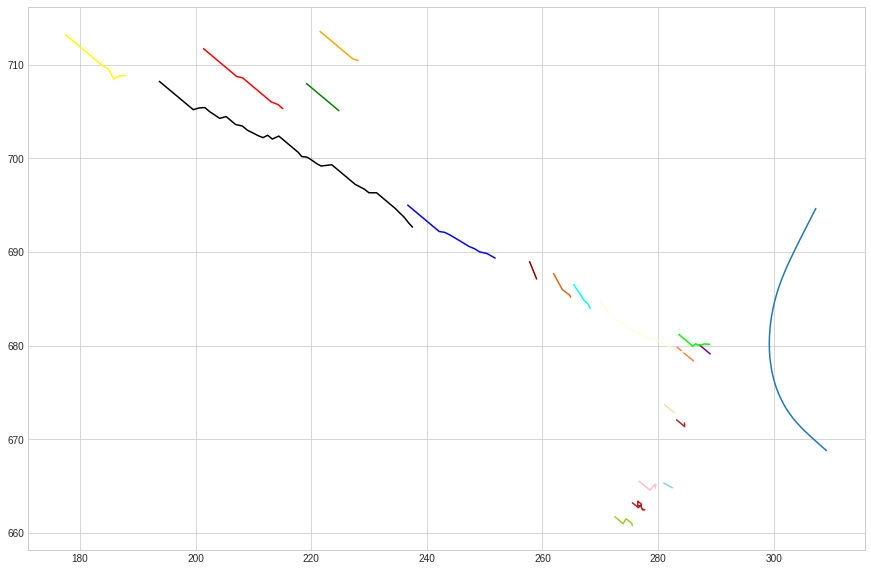

In [431]:
tracks = tracker.getHistory()
N = len(tracks)
print(f"Total number of tracks = {N}")

fig, ax = plt.subplots(1,1,figsize=(15,10))
colors = ['blue','orange','green','red','black','pink','yellow','purple',"brown","firebrick","coral","lime",
                      "wheat", "yellowgreen", "lightyellow", "skyblue", "cyan", "chocolate", "maroon", "peru", "blueviolet"]

ego_path = dataset.getEgoPath()[:n_frames]
ax.plot(ego_path[:,0], ego_path[:,1])
for idx,trk in enumerate(tracks):
    if 1:#trk.confirmed:
        history = trk.getHistory()
        print(history.shape)
        ax.plot(history[:,0], history[:,1], color=colors[idx])
        history_len = history.shape[0]
        dx = history[int(history_len / 2) + 1,0]-history[int(history_len / 2) - 1,0]
        dy = history[int(history_len / 2) + 1,1]-history[int(history_len / 2) - 1,1]
        #ax.arrow(np.mean(history[:,0]), np.mean(history[:,1]), dx[0], dy[0], shape='full', lw=13, length_includes_head=True, head_width=.05)